### Recommendation Engine Project

Building a recommendation system pipeline to be integrated with IBM AccessHub as an AI based Access Management. This system is using the User-Based collaborative filtering algorithm K-Nearest Neighbor (KNN)  to recommend the least and best access to a new user based on the similarity of the common attributes of that user to his/her peers.

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import missingno as msno 
import requests
import json
import time
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys, os
from contextlib import contextmanager
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from pandas_profiling import ProfileReport

### Data Dictionary

The data dictionary for the dataset could be found here:
https://ibm.ent.box.com/notes/821944820454

### Loading the original dataset

In [2]:
originaldata1 = pd.read_csv('EPM_Production_User_Data___Latest_Account_Attributes_05Mar2021.csv')

### Target Columns

- BLACKOUT
- GEO
- UNIFIED TAXONOMY
- BUSINESS UNIT
- APPLICATIONS
- PERSONAS
- BLACKOUT ACCESS

### Examining the original dataset 

#### Loading some functions for EDA

In [3]:
def eda(data):
    output=[]
    for col in data.columns:
        duplicatedvalue = data[col].duplicated().sum()
        duplicatedrows = data.duplicated().sum()
        missingvalue = np.sum(pd.isna(data[col]))
        uniquevalue = data[col].nunique()
        datatype = str(data[col].dtype)
        
        output.append([col, duplicatedvalue, duplicatedrows, missingvalue, uniquevalue, datatype])
        
    output = pd.DataFrame(output) 
    output.columns = ['Features', 'Duplicated Values', 'Duplicated Rows', 'Missing Values', 'Unique Values', 'Data Type']
    display(output)

In [4]:
def perc_on_bar(plot, feature): #Percentage bar plot for data visualization
    total = len(feature)
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage
    plt.show()

In [5]:
originaldata1.shape

(6004, 26)

In [6]:
eda(originaldata1)

Features  Duplicated Values  Duplicated Rows  \
0                 APPLICATION               6003                0   
1                        CNUM                 21                0   
2                   USER NAME                 45                0   
3                  USER EMAIL                 21                0   
4                ACCOUNT NAME                  0                0   
5          ACCOUNT CREATED ON               2957                0   
6          ACCOUNT UPDATED ON               5784                0   
7           DEFAULT SELECTION               6002                0   
8                    BLACKOUT               6002                0   
9                 DEFAULT GEO               5999                0   
10              REQUIRED GEOS               5997                0   
11                        GEO               5967                0   
12                     MARKET               5980                0   
13               TYPE OF UNIT               6001                0   
14  REQUIRED UNIFIED TAXONOMY               6001                0   
15           UNIFIED TAXONOMY               5972                0   
16    REQUIRED BUSINESS UNITS               5998                0   
17      DEFAULT BUSINESS UNIT               5996                0   
18              BUSINESS UNIT               5811                0   
19                RESTRICTION               5998                0   
20             INDUSTRY GROUP               5976                0   
21               APPLICATIONS               5979                0   
22                   PERSONAS               5945                0   
23            BLACKOUT ACCESS               5984                0   
24                ENTITLEMENT               6003                0   
25          ENTITLEMENT VAULE               6003                0   

    Missing Values  Unique Values Data Type  
0                0              1    object  
1                0           5983    object  
2                0           5959    object  
3                0           5983    object  
4                0           6004    object  
5                0           3047    object  
6                0            220    object  
7                0              2    object  
8                0              2    object  
9             5482              4    object  
10             457              6    object  
11            2316             36    object  
12            4525             23    object  
13             469              2    object  
14            5865              2    object  
15            5866             31    object  
16             581              5    object  
17            5484              7    object  
18            2326            192    object  
19               0              6    object  
20            5956             27    object  
21            2675             24    object  
22            2675             58    object  
23            3437             19    object  
24               0              1    object  
25               0              1    object

#### Insights:
- The dataset has 6004 rows and 26 columns
- The dataset doesn't have any numerical values
- There is only 1 unique value in APPLICATION, ENTITLEMENT and ENTITLEMENT VAULE.
- Column ACCOUNT CREATED ON and ACCOUNT UPDATED ON will not be useful. 
- Column DEFAULT SELECTION, BLACKOUT, TYPE OF UNIT and REQUIRED UNIFIED TAXONOMY could be consolidated into other columns.
- The dataset doesn't have any duplicated rows

### Visualising the missing values in original dataset

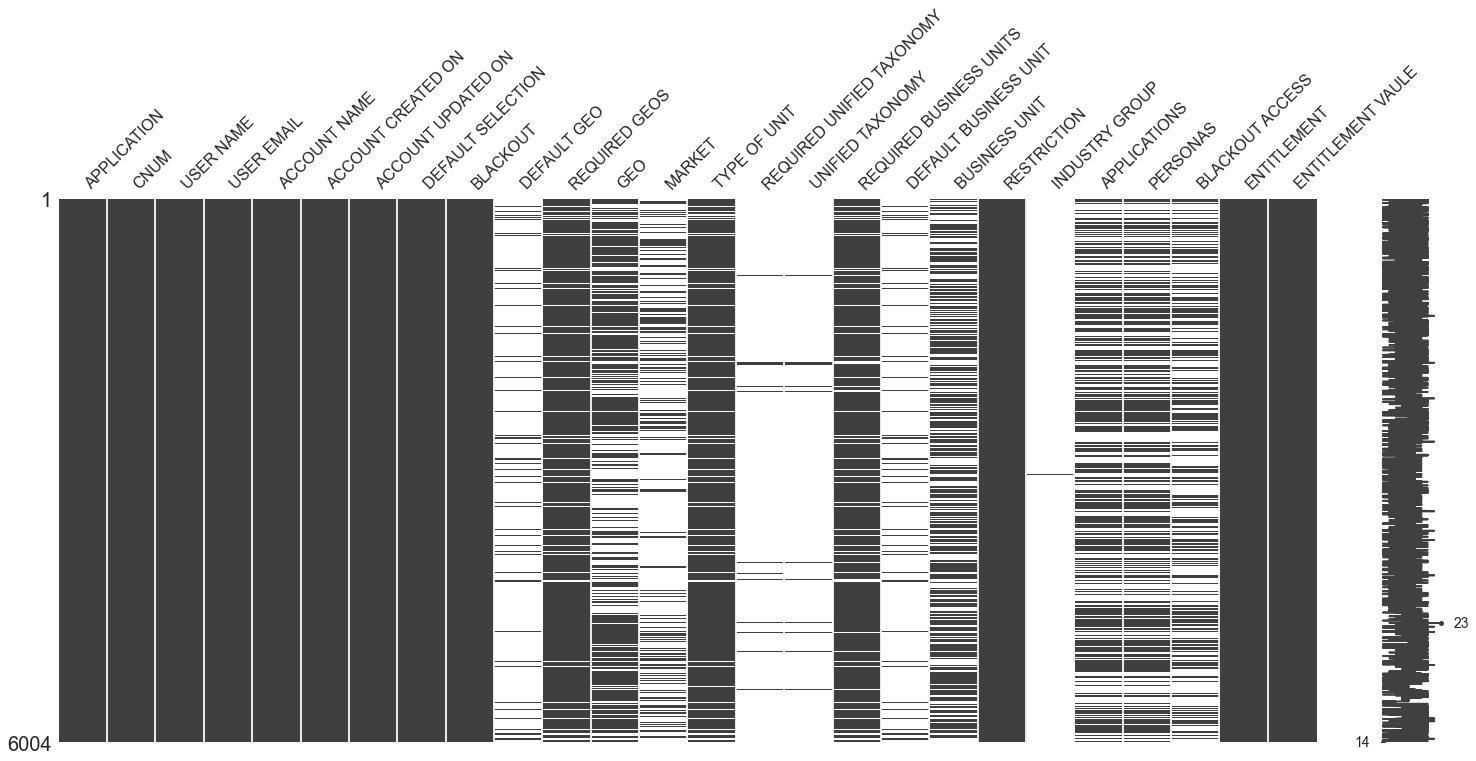

In [7]:
msno.matrix(originaldata1)
plt.show()

#### Insights:
- The number of empty cells are high. 
- There are 14 columns with missing values. 
- 23% of the data is missing

### Loading the second version of dataset

In [8]:
originaldata2 = pd.read_csv('EPM_Production_User_Data_Original_Final.csv')

### Examining the second version of dataset

#### Notes:
After interviewing with the dataset owner and gathering some insights from the original dataset the following changes have been made:
- The columns APPLICATION, ENTITLEMENT and ENTITLEMENT VAULE only had 1 unique which got dropped. 
- Column CNUM, USER NAME, ACCOUNT CREATED ON and ACCOUNT UPDATED ON didn't have any value which got dropped.
- Column INDUSTRY GROUP	got droped due to high percentage of missing values which got dropped.
- Column ACCOUNT NAME had the same value as USER NAME which got dropped.

In [9]:
originaldata2.shape

(6004, 17)

In [10]:
eda(originaldata2)

Features  Duplicated Values  Duplicated Rows  \
0                  USER EMAIL                 21                6   
1           DEFAULT SELECTION               6002                6   
2                    BLACKOUT               6002                6   
3                 DEFAULT GEO               5999                6   
4               REQUIRED GEOS               5997                6   
5                         GEO               5966                6   
6                      MARKET               5979                6   
7                TYPE OF UNIT               6002                6   
8   REQUIRED UNIFIED TAXONOMY               6001                6   
9            UNIFIED TAXONOMY               5972                6   
10    REQUIRED BUSINESS UNITS               5997                6   
11      DEFAULT BUSINESS UNIT               5995                6   
12              BUSINESS UNIT               5814                6   
13                RESTRICTION               5998                6   
14               APPLICATIONS               5980                6   
15                   PERSONAS               5945                6   
16            BLACKOUT ACCESS               5983                6   

    Missing Values  Unique Values Data Type  
0                0           5983    object  
1                0              2    object  
2                0              2    object  
3                0              5    object  
4                0              7    object  
5                0             38    object  
6                0             25    object  
7                0              2    object  
8                0              3    object  
9                0             32    object  
10               0              7    object  
11               0              9    object  
12               0            190    object  
13               0              6    object  
14               0             24    object  
15               0             59    object  
16               0             21    object

#### Insights:
- The dataset has 6004 rows and 17 columns.
- The data type of all columns is object.
- There are 6 duplicated rows.

#### Overall the following columns got dropped:
- APPLICATION
- ENTITLEMENT
- ENTITLEMENT VAULE
- CNUM
- USER NAME
- ACCOUNT CREATED ON
- ACCOUNT UPDATED ON
- INDUSTRY GROUP
- ACCOUNT NAME

#### Examining the target columns

#### BLACKOUT

In [11]:
print ('\n','Number of unique values:', originaldata2['BLACKOUT'].nunique(),'\n','Unique values:','\n',originaldata2['BLACKOUT'].unique())


 Number of unique values: 2 
 Unique values: 
 ['YES' 'NO']


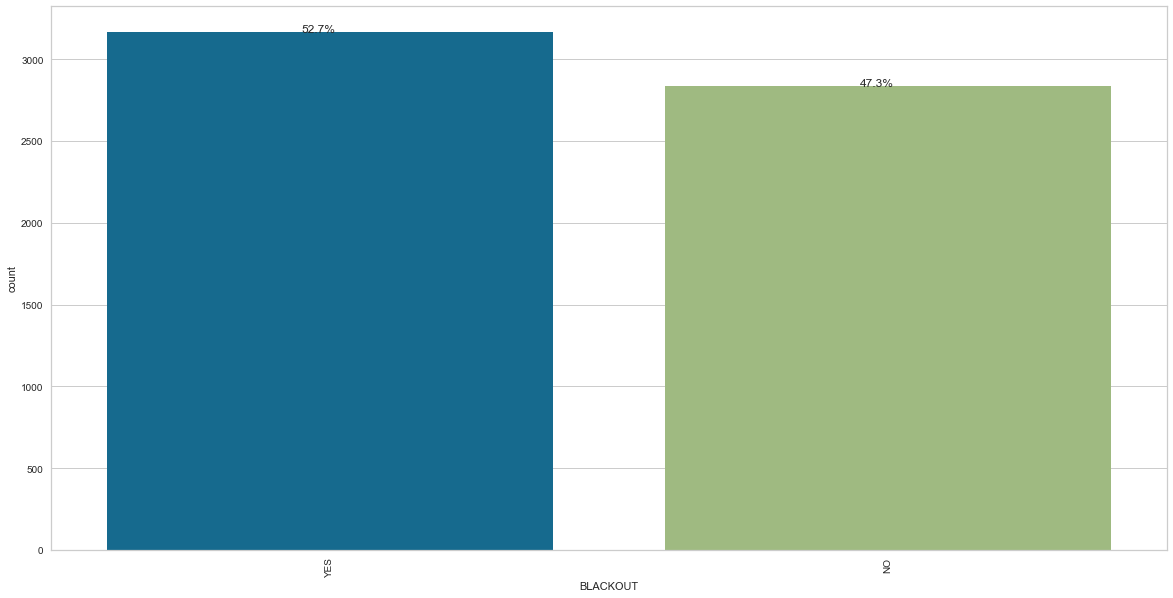

In [12]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2.BLACKOUT)
perc_on_bar(ax, originaldata2.BLACKOUT)

#### GEO

In [13]:
print ('\n','Number of unique values:', originaldata2['GEO'].nunique(),'\n','Unique values:','\n',originaldata2['GEO'].unique())


 Number of unique values: 38 
 Unique values: 
 ['JAPAN' 'AMERICAS' 'EMEA' 'DEFAULT SELECTION' 'Worldwide '
 'AMERICAS,EMEA,JAPAN,APAC' 'All Geos' 'APAC' 'APAC,EMEA' 'EMEA,APAC'
 'AMERICAS,EMEA' 'APAC,JAPAN,EMEA,AMERICAS' 'JAPAN,APAC'
 'JAPAN,APAC,AMERICAS,EMEA' 'AMERICAS,APAC' 'APAC,JAPAN'
 'APAC,EMEA,AMERICAS' 'EMEA,AMERICAS,APAC' 'JAPAN,APAC,EMEA,AMERICAS'
 'AMERICAS,APAC,EMEA,JAPAN' 'EMEA,AMERICAS' 'AMERICAS,EMEA,APAC,JAPAN'
 'APAC,AMERICAS' 'AMERICAS,APAC,EMEA' 'APAC,JAPAN,EMEA' 'APAC,EMEA,JAPAN'
 'APAC,EMEA,JAPAN,AMERICAS' 'EMEA,APAC,AMERICAS' 'AMERICAS,EMEA,APAC'
 'EMEA,AMERICAS,JAPAN,APAC' 'APAC,JAPAN,AMERICAS,EMEA'
 'APAC,EMEA,AMERICAS,JAPAN' 'EMEA,APAC,JAPAN' 'AMERICAS,JAPAN,APAC,EMEA'
 'AMERICAS,EMEA,JAPAN' 'AMERICAS,APAC,JAPAN' 'EMEA,APAC,AMERICAS,JAPAN'
 'JAPAN,EMEA,AMERICAS']


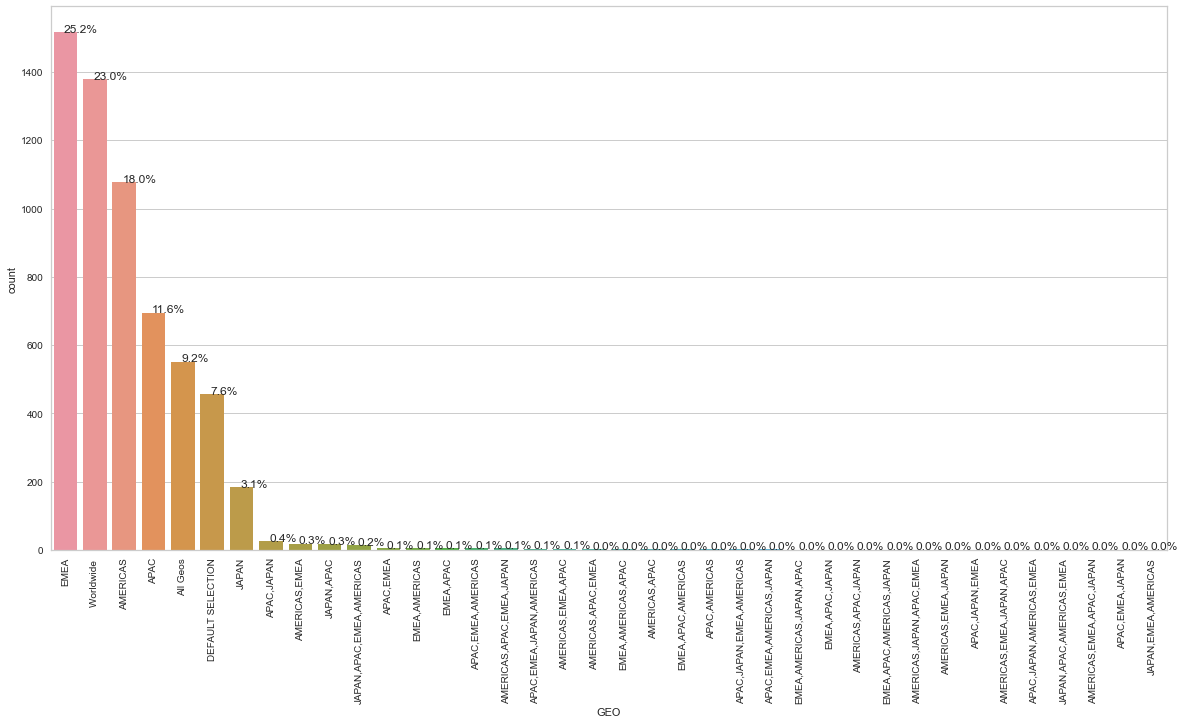

In [14]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2.GEO, order=originaldata2['GEO'].value_counts().index)
perc_on_bar(ax, originaldata2.GEO)

- There are multiple values grouped together in one cell.

#### UNIFIED TAXONOMY

In [15]:
print ('\n','Number of unique values:', originaldata2['UNIFIED TAXONOMY'].nunique(),'\n','Unique values:','\n',originaldata2['UNIFIED TAXONOMY'].unique())


 Number of unique values: 32 
 Unique values: 
 ['NOT APPLICABLE' 'Cloud and Data Platform'
 'Cloud and Data Platform,Security,Watson Health,Cognitive Applications'
 'Cloud and Data Platform,Cognitive Applications'
 'Cloud and Data Platform,Cognitive Applications,GBS,Watson Health' 'GBS'
 'Cloud and Data Platform,IBM Systems,Security,Watson Health,Cognitive Applications'
 'GTS'
 'GBS,Cognitive Applications,GTS,IBM Systems,Security,Watson Health,Cloud and Data Platform,IGF'
 'Security'
 'Cloud and Data Platform,Cognitive Applications,Security,Watson Health'
 'Cloud and Data Platform,Cognitive Applications,GBS,GTS,IBM Systems,IGF,Security,Watson Health'
 'Cloud and Data Platform,GTS,Watson Health,IBM Systems'
 'Cognitive Applications,Cloud and Data Platform' 'GBS,GTS'
 'Cloud and Data Platform,IBM Systems,Security,Cognitive Applications,Watson Health'
 'IBM Systems' 'Cognitive Applications'
 'IBM Systems,Cloud and Data Platform,GBS,GTS,Security'
 'Cloud and Data Platform,GTS,GBS,Cogniti

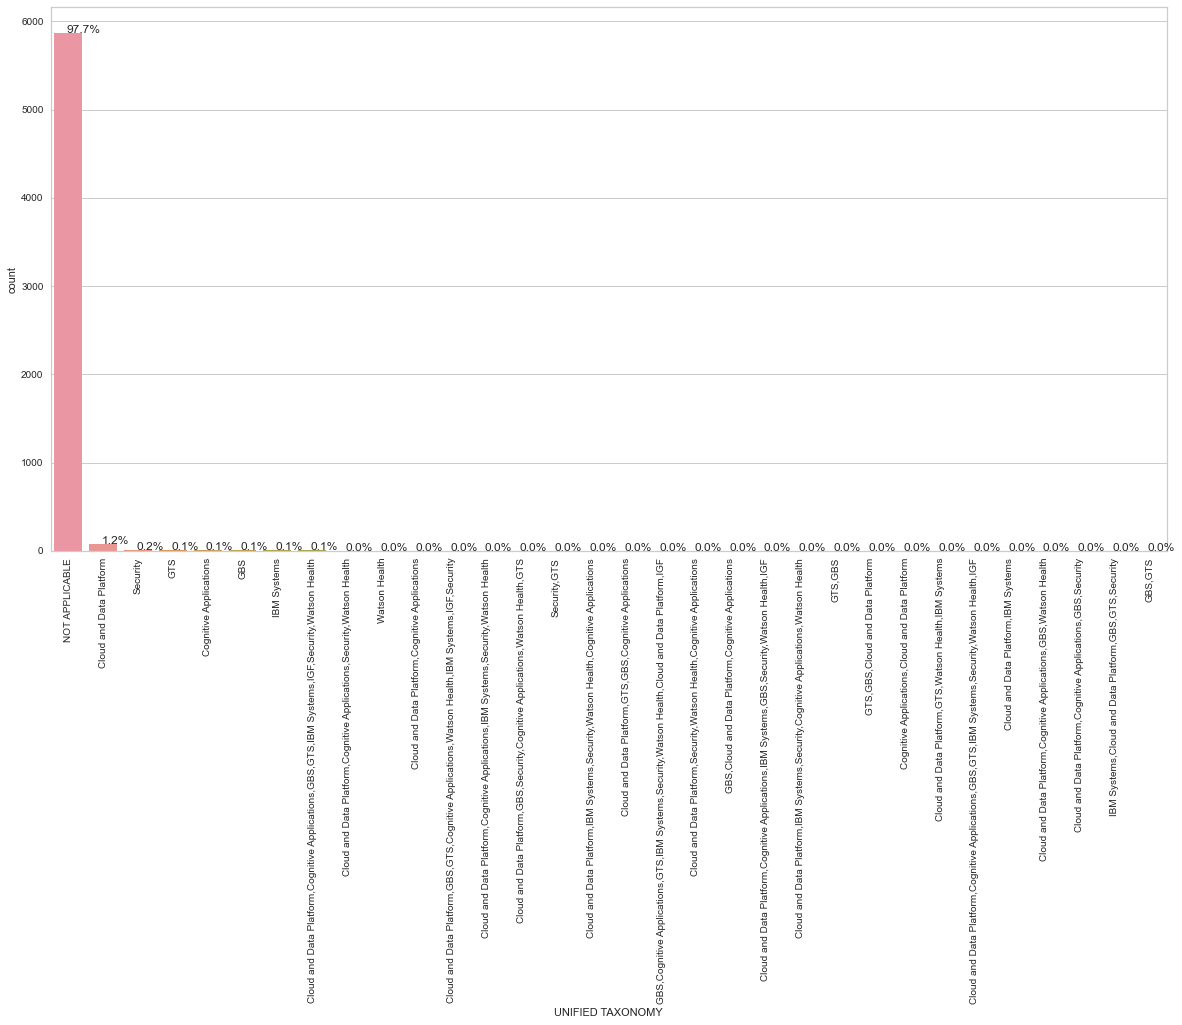

In [16]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2['UNIFIED TAXONOMY'], order=originaldata2['UNIFIED TAXONOMY'].value_counts().index)
perc_on_bar(ax, originaldata2['UNIFIED TAXONOMY'])

- There are multiple values grouped together in one cell.

#### BUSINESS UNIT

In [17]:
print ('\n','Number of unique values:', originaldata2['BUSINESS UNIT'].nunique(),'\n','Unique values:','\n',originaldata2['BUSINESS UNIT'].unique())


 Number of unique values: 190 
 Unique values: 
 ['GBS'
 'Public Cloud IaaS Platform,Cloud and Cognitive Software,GTS Dual,IBM Systems'
 'GBS,GTS Dual,Public Cloud IaaS Platform'
 'Cloud and Cognitive Software,GTS Dual' 'GTS Dual' 'DEFAULT SELECTION'
 'Corp HQ Above Business Unit' 'All Business Units'
 'Cloud and Cognitive Software' 'Total Global Markets'
 'Public Cloud IaaS Platform,GTS Dual,Cloud and Cognitive Software'
 'Total IBM' 'IBM Systems'
 'Cloud and Cognitive Software,GTS Dual,IBM Systems,Public Cloud IaaS Platform'
 'Cloud and Cognitive Software,IBM Systems,GBS,GTS Dual'
 'IBM Systems,IBM Systems,Public Cloud IaaS Platform' 'GTS Dual,GBS'
 'Cloud and Cognitive Software,Public Cloud IaaS Platform,IBM Systems'
 'GBS,IBM Systems' 'NOT APPLICABLE' 'GTS Dual,IBM Systems'
 'Public Cloud IaaS Platform' 'IGF'
 'Cloud and Cognitive Software,Public Cloud IaaS Platform,GTS Dual,IBM Systems'
 'IBM Systems,IGF' 'GBS,GTS Dual'
 'IBM Systems,Cloud and Cognitive Software'
 'GBS,Cloud and 

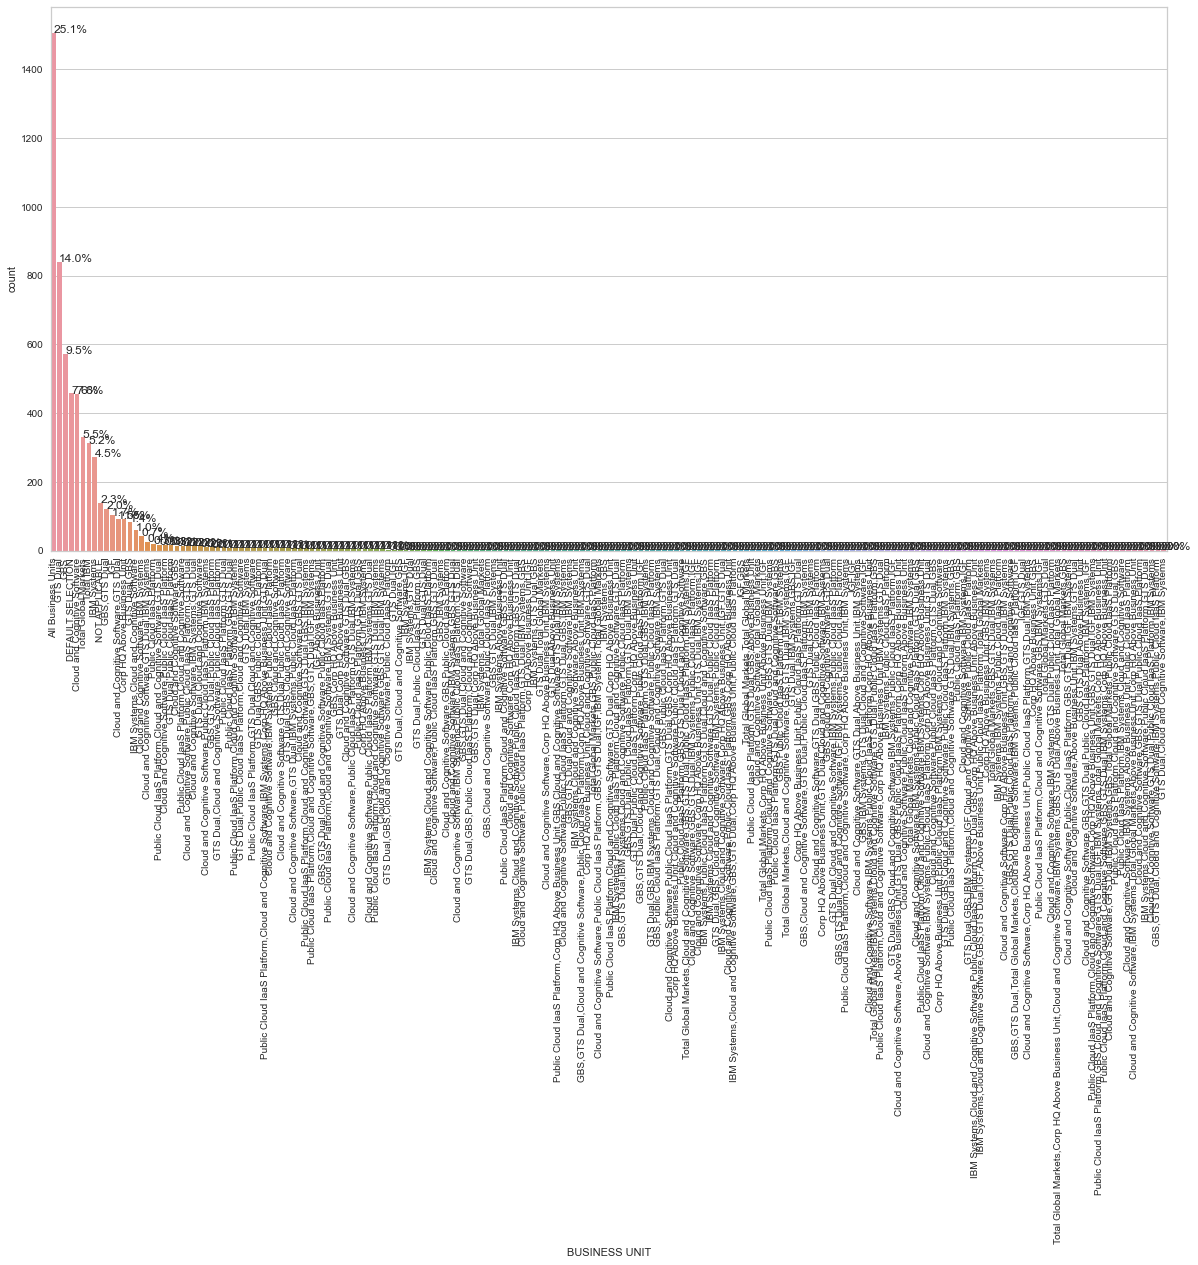

In [18]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2['BUSINESS UNIT'], order=originaldata2['BUSINESS UNIT'].value_counts().index)
perc_on_bar(ax, originaldata2['BUSINESS UNIT'])

- There are multiple values grouped together in one cell.

#### APPLICATIONS

In [19]:
print ('\n','Number of unique values:', originaldata2['APPLICATIONS'].nunique(),'\n','Unique values:','\n',originaldata2['APPLICATIONS'].unique())


 Number of unique values: 24 
 Unique values: 
 ['WWConsol' 'NO APPLICATIONS' 'WWBalsht' 'WWConsol, WWBalsht'
 'DEFAULT SELECTION' 'WWConsol, WWGID, WWBalsht' 'WWConsol, WWGID' 'WWGID'
 'WWConsol, WWBalsht, WWGID' 'Cash IQ' 'WWBalsht, WWConsol, WWGID'
 'WWBalsht, WWGID, WWConsol' 'WWBalsht, WWGID'
 'WWConsol,  WWGID, Cash IQ, WWBalsht, WWGID' 'WWBalsht, WWConsol'
 'WWConsol,  WWGID, WWBalsht' 'WWGID, Cash IQ' 'WWPen'
 'WWBalsht,WWConsol,WWGID' 'WWConsol,  WWBalsht'
 'WWConsol, WWBalsht, Cash IQ' 'WWConsol,  WWBalsht, WWBalsht'
 'WWGID, WWBalsht' 'WWConsol, WWBalsht, Cash IQ, WWGID']


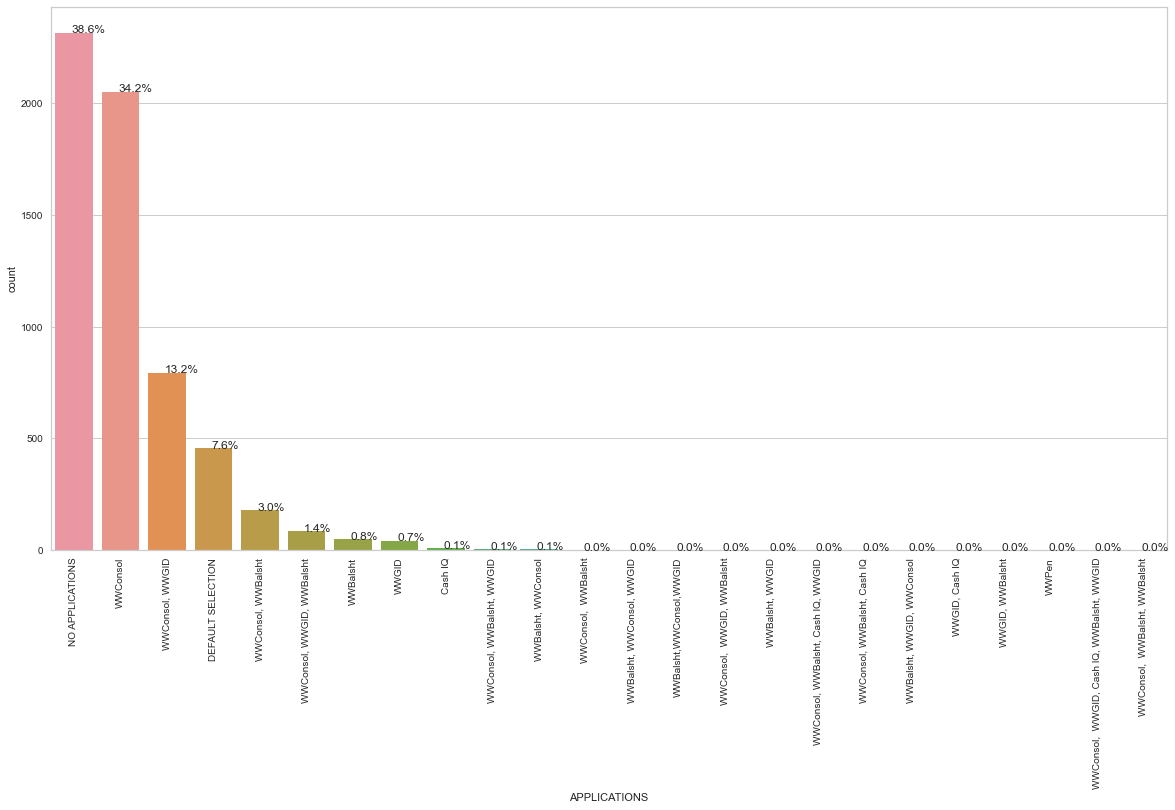

In [20]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2['APPLICATIONS'], order=originaldata2['APPLICATIONS'].value_counts().index)
perc_on_bar(ax, originaldata2['APPLICATIONS'])

- There are multiple values grouped together in one cell.

#### PERSONAS

In [21]:
print ('\n','Number of unique values:', originaldata2['PERSONAS'].nunique(),'\n','Unique values:','\n',originaldata2['PERSONAS'].unique())


 Number of unique values: 59 
 Unique values: 
 ['WWConsol:Analyst - Read' 'NO PERSONAS' 'WWBalsht:Analyst - Read'
 'WWConsol:Analyst - Read, WWBalsht:Analyst - Read'
 'WWConsol:Planner - Read/Write' 'DEFAULT SELECTION'
 'WWConsol:Analyst - Read, WWGID:Planner - Read/Write, WWBalsht:Analyst - Read'
 'WWConsol:Analyst - Read, WWGID:Analyst - Read'
 'WWConsol:Planner - Read/Write, WWGID:Planner - Read/Write'
 'WWConsol:Analyst - Read, WWGID:Planner - Read/Write'
 'WWConsol:Planner - Read/Write, WWGID:Analyst - Read'
 'WWConsol:Planner - Read/Write, WWBalsht:Analyst - Read'
 'WWGID:Analyst - Read'
 'WWConsol:Planner - Read/Write, WWGID:Planner - Read/Write, WWBalsht:Analyst - Read'
 'WWBalsht:Planner - Read/Write'
 'WWGID:Analyst - Read, WWConsol:Analyst - Read, WWBalsht:Planner - Read/Write'
 'WWConsol:Analyst - Read, WWGID:Analyst - Read, WWBalsht:Analyst - Read'
 'WWConsol:Planner - Read/Write,  WWGID:Planner - Read/Write'
 'WWConsol:Planner - Read/Write, WWGID:Planner - Read/Write, W

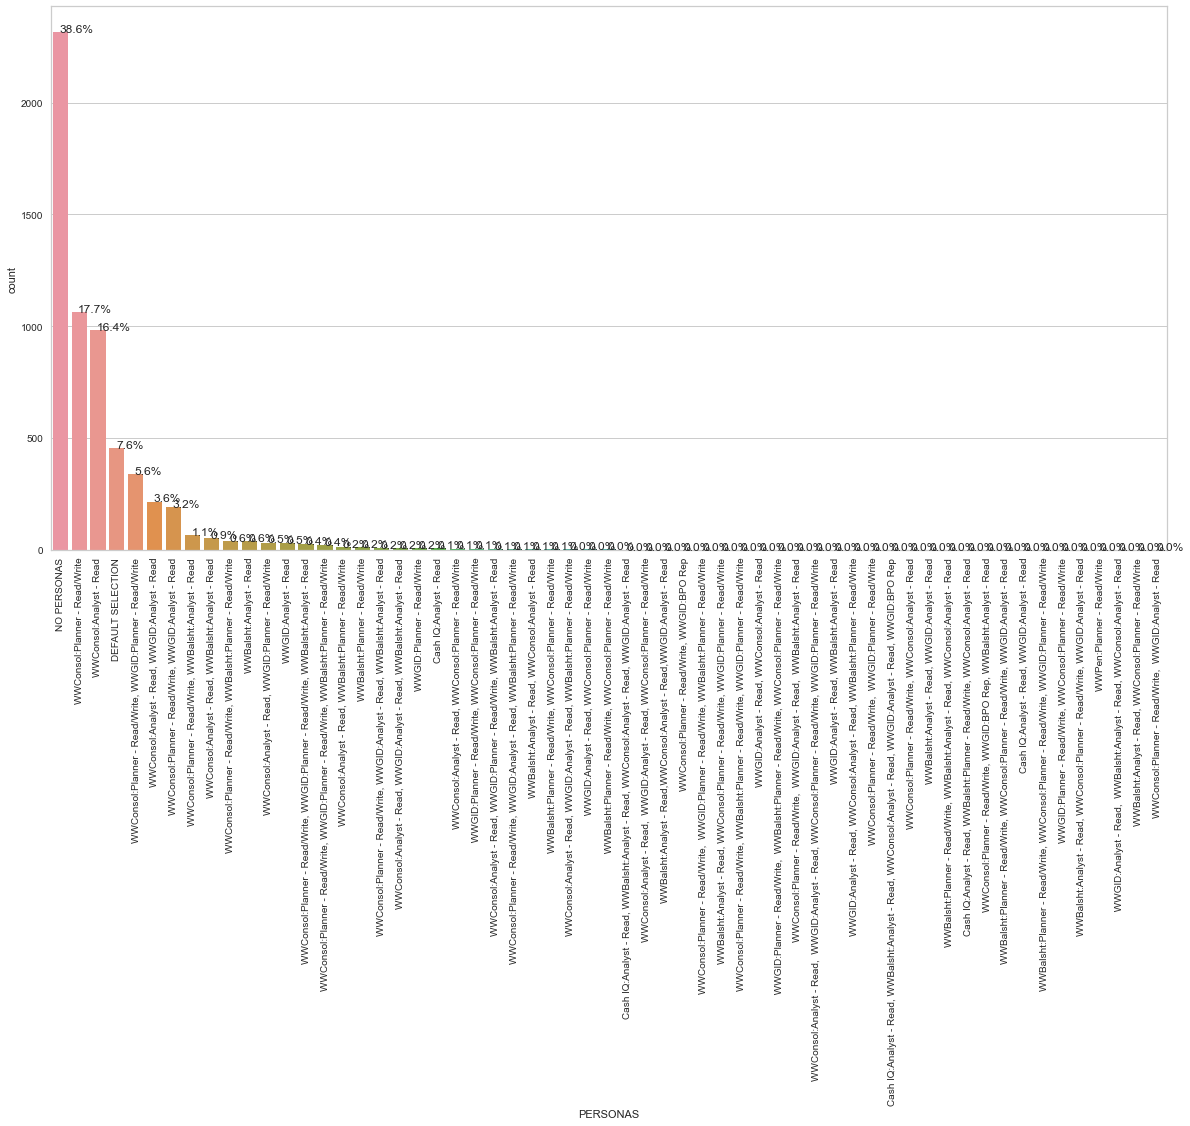

In [22]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2['PERSONAS'], order=originaldata2['PERSONAS'].value_counts().index)
perc_on_bar(ax, originaldata2['PERSONAS'])

- There are multiple values grouped together in one cell.

#### BLACKOUT ACCESS

In [23]:
print ('\n','Number of unique values:',originaldata2['BLACKOUT ACCESS'].nunique(),'\n','Unique values:','\n',originaldata2['BLACKOUT ACCESS'].unique())


 Number of unique values: 21 
 Unique values: 
 ['WWConsol:Blackout' 'NO BLACKOUT ACCESS'
 'WWConsol:Blackout, WWBalsht:Blackout' 'DEFAULT SELECTION'
 'WWConsol:Blackout, WWGID:Blackout, WWBalsht:Blackout'
 'WWConsol:Blackout, WWGID:Blackout' 'WWGID:Blackout'
 'WWGID:Blackout, WWConsol:Blackout' 'WWBalsht:Blackout'
 'WWGID:Blackout, WWBalsht:Blackout'
 'WWBalsht:Blackout, WWConsol:Blackout, WWGID:Blackout'
 'WWGID:Blackout,  WWBalsht:Blackout, WWConsol:Blackout'
 'WWBalsht:Blackout, WWConsol:Blackout'
 'WWGID:Blackout, WWBalsht:Blackout, WWConsol:Blackout'
 'WWConsol:Blackout, WWBalsht:Blackout, WWGID:Blackout'
 'WWBalsht:Blackout, WWGID:Blackout' ' WWBalsht:Blackout'
 ' WWGID:Blackout' ' WWGID:Blackout, WWConsol:Blackout'
 'WWBalsht:Blackout,WWConsol:Blackout,WWGID:Blackout'
 ' WWBalsht:Blackout, WWConsol:Blackout']


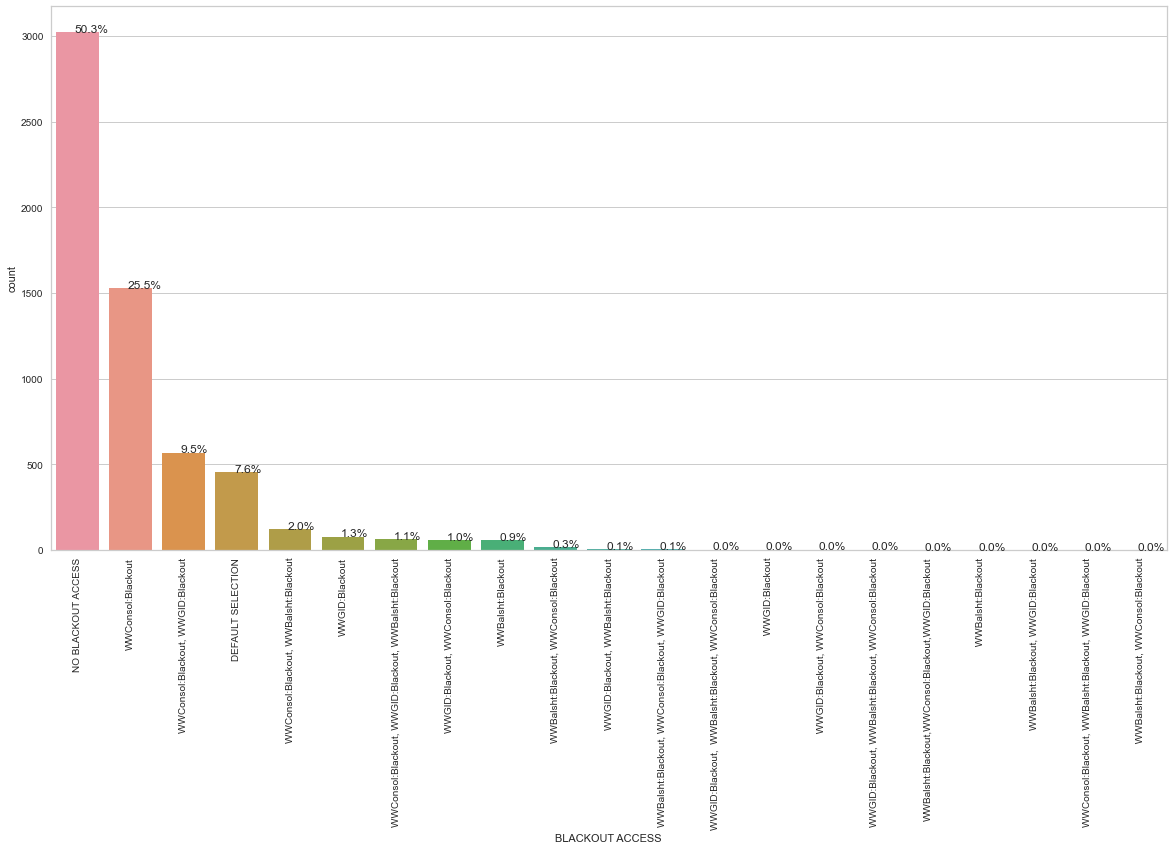

In [24]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(originaldata2['BLACKOUT ACCESS'], order=originaldata2['BLACKOUT ACCESS'].value_counts().index)
perc_on_bar(ax, originaldata2['BLACKOUT ACCESS'])

- There are multiple values grouped together in one cell.

### Visualising the second version of dataset's missing values 

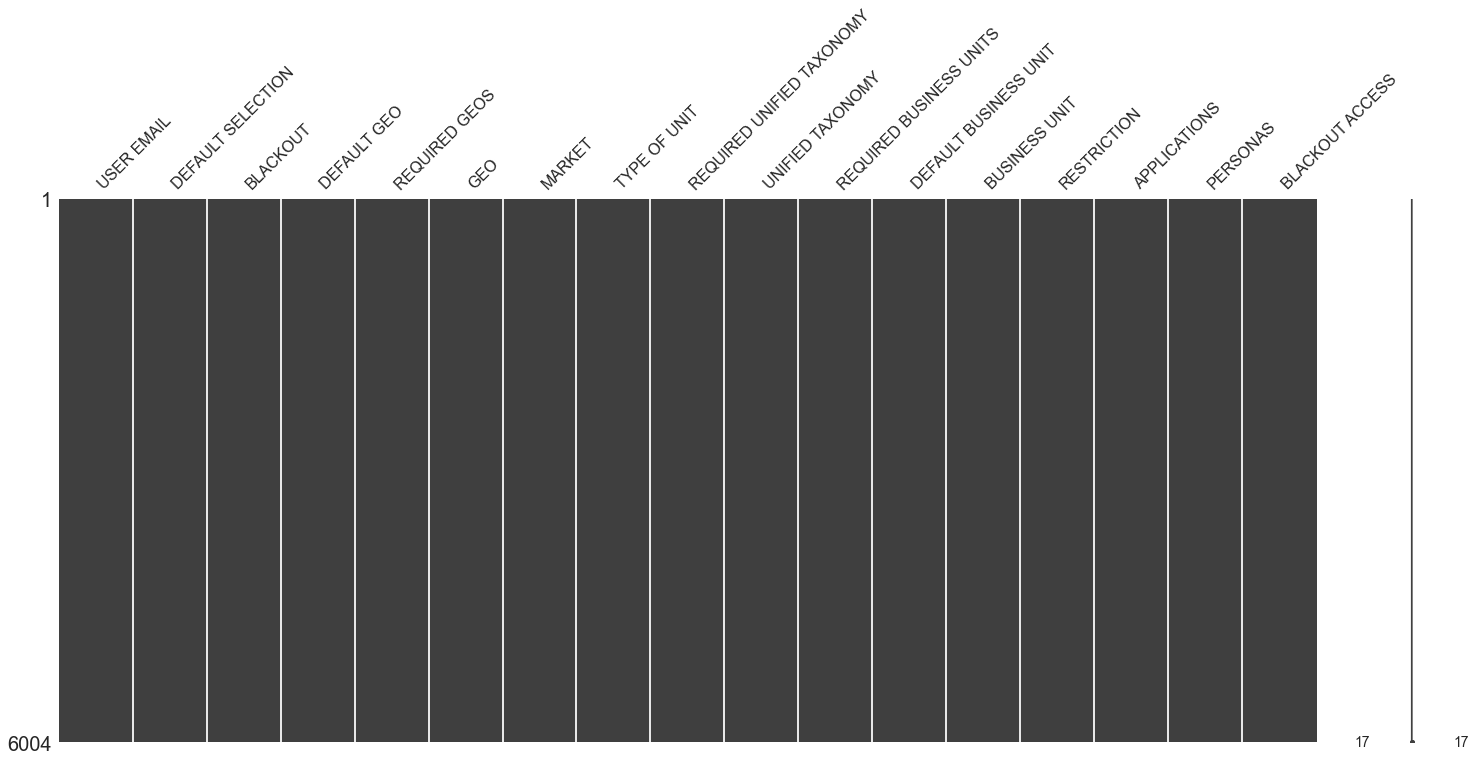

In [25]:
msno.matrix(originaldata2)
plt.show()

#### Insights:
- 17 columns
- No missing values

### Data Enrichment

<img src="enrichment.png">

#### Phase 1
#### Employee Email Address Enrichment

In [26]:
dataset = pd.read_csv('EPM_Production_User_Data_Original_Final.csv') #import the dataset

In [27]:
class useratt_dict(dict):
  
    def __init__(self):
        self = dict()
          
    def add(self, key, value):
        self[key] = value

In [28]:
def extract_bluepage_data(email): #extract users' attributes via their their email addresses.
    Country, Country_Code, Manager_County_Code, Manager_UID, Role, Org_Code, Div_Code, Company_Code, Workday_ID, Department_Code = None, None, None, None, None, None, None, None, None, None
    base_url1 = bluepage_api_url = "https://bluepages.ibm.com/BpHttpApisv3/slaphapi?ibmperson/mail={}.list,printable/byjson?*".format(email)
    response1 = requests.get(base_url1)
    if response1.status_code != 200:
        time.sleep(5)  # Give the api some space and try again
        None, None, None, None, None, None, None, None, None, None
    try:
        results = response1.json()
        useratt_obj = useratt_dict()
        useratt = results['search']['entry'][0]['attribute']
        
        for i in range(len(useratt)):
            useratt_obj.add(useratt[i]['name'], useratt[i]['value'][0])
        
        Country = useratt_obj['co']
        Country_Code = useratt_obj['employeeCountryCode']
        Manager_County_Code = useratt_obj['managerCountryCode']
        Manager_UID = useratt_obj['manager'][4:13]
        Role = useratt_obj['jobResponsibilities']
        Org_Code = useratt_obj['hrOrgUnitCode']
        Div_Code = useratt_obj['div']
        Company_Code = useratt_obj['hrCompanyCode']
        Workday_ID = useratt_obj['workerId']
        Department_Code = useratt_obj['dept']
        #IOT = useratt_obj['iot']
    except:
        
        pass
    return Country, Country_Code, Manager_County_Code, Manager_UID, Role, Org_Code, Div_Code, Company_Code, Workday_ID, Department_Code

def enrich_dataset(dataset):
    column_name = 'USER EMAIL' # the name of the column in the dataset where it has email addresses.
    email_value = dataset[column_name]
    Country, Country_Code, Manager_County_Code, Manager_UID, Role, Org_Code, Div_Code, Company_Code, Workday_ID, Department_Code = extract_bluepage_data(email_value)
    dataset['Country'] = Country
    dataset['Country_Code'] = Country_Code
    dataset['Manager_County_Code'] = Manager_County_Code
    dataset['Manager_UID'] = Manager_UID
    dataset['Role'] = Role
    dataset['Org_Code'] = Org_Code
    dataset['Div_Code'] = Div_Code
    dataset['Company_Code'] = Company_Code
    dataset['Workday_ID'] = Workday_ID
    dataset['Department_Code'] = Department_Code
    return dataset

print(datetime.now())

2021-08-19 12:55:13.631292


#### Notes:
#### The user's email address was used for gathering the following information form the BluePage's API.
- Country
- Country_Code
- Role
- Org_Code
- Dept_Code
- Div_Code
- Department_Code
- Manager_Country_Code
- Workday_ID
- Manager_UID

#### Enriching the dataset

#### Dropping the missing values

#### Dropping the duplicated rows

### Save Dataset (Phase 1): Enriched, No Missing Values, No Duplicated Data

#### Loading the enriched dataset

In [29]:
dataset = pd.read_csv('Data_Original_Cleaned_Enriched-e.csv')
dataset.shape

(3834, 27)

##### After the data enrichment the dataset has 9 additional columns
- Country
- Country_Code
- Role
- Org_Code
- Dept_Code
- Div_Code
- Department_Code
- Manager_Country_Code
- Workday_ID
- Manager_UID

In [30]:
eda(dataset)

Features  Duplicated Values  Duplicated Rows  \
0                  USER EMAIL                 13                0   
1           DEFAULT SELECTION               3832                0   
2                    BLACKOUT               3832                0   
3                 DEFAULT GEO               3829                0   
4               REQUIRED GEOS               3827                0   
5                         GEO               3801                0   
6                      MARKET               3809                0   
7                TYPE OF UNIT               3832                0   
8   REQUIRED UNIFIED TAXONOMY               3831                0   
9            UNIFIED TAXONOMY               3812                0   
10    REQUIRED BUSINESS UNITS               3827                0   
11      DEFAULT BUSINESS UNIT               3825                0   
12              BUSINESS UNIT               3690                0   
13                RESTRICTION               3828                0   
14               APPLICATIONS               3815                0   
15                   PERSONAS               3783                0   
16            BLACKOUT ACCESS               3814                0   
17                    Country               3766                0   
18               Country_Code               3762                0   
19        Manager_County_Code               3766                0   
20                Manager_UID               2456                0   
21                       Role                490                0   
22                   Org_Code               3626                0   
23                   Div_Code               3740                0   
24               Company_Code               3733                0   
25                 Workday_ID                 24                0   
26            Department_Code               2277                0   

    Missing Values  Unique Values Data Type  
0                0           3821    object  
1                0              2    object  
2                0              2    object  
3                0              5    object  
4                0              7    object  
5                0             33    object  
6                0             25    object  
7                0              2    object  
8                0              3    object  
9                0             22    object  
10               0              7    object  
11               0              9    object  
12               0            144    object  
13               0              6    object  
14               0             19    object  
15               0             51    object  
16               0             20    object  
17               0             68    object  
18               0             72    object  
19               0             68    object  
20               0           1378    object  
21              56           3343    object  
22               0            208    object  
23               0             94    object  
24               0            101     int64  
25               0           3810     int64  
26               0           1557    object

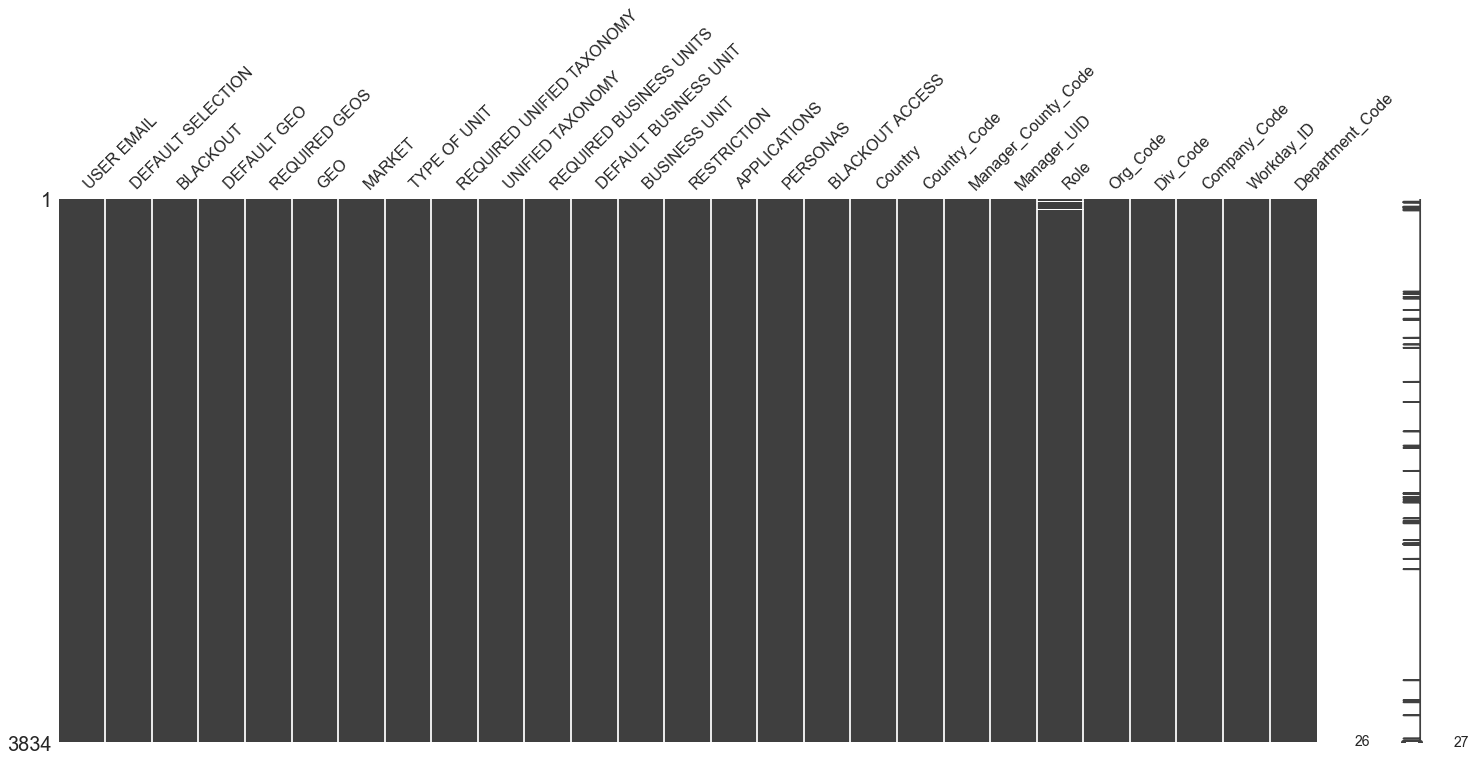

In [31]:
msno.matrix(dataset)
plt.show()

#### Phase 2
#### Manager UID Enrichment
- Manager_Workday_ID

In [32]:
def extract_bluepage_data(uid):
    Manager_Workday_ID = None
    base_url = bluepage_api_url = "https://bluepages.ibm.com/BpHttpApisv3/slaphapi?ibmperson/(uid={})/byjson?*".format(uid)
    response = requests.get(base_url)
    if response.status_code != 200:
        time.sleep(5)  # Give the api some space and try again
        None
    try:
        results = response.json()
        useratt_obj = useratt_dict()
        useratt = results['search']['entry'][0]['attribute']
        
        for i in range(len(useratt)):
            useratt_obj.add(useratt[i]['name'], useratt[i]['value'][0])
        
        Manager_Workday_ID = useratt_obj['workerId']

    except:
        
        pass
    return Manager_Workday_ID

def enrich_dataset(dataset):
    column_name = 'Manager_UID'
    uid_value = dataset[column_name]
    Manager_Workday_ID = extract_bluepage_data(uid_value)

    dataset['Manager_Workday_ID'] = Manager_Workday_ID

    return dataset

print(datetime.now())

2021-08-19 12:55:14.526171


#### Dropping the missing values

#### Dropping the duplicated rows

### Save Dataset (Phase 2): Enriched, No Missing Values, No Duplicated Data

In [33]:
dataset = pd.read_csv('Data_Original_Cleaned_Enriched-e_Enriched-m.csv')
dataset.shape

(3775, 28)

In [34]:
eda(dataset)

Features  Duplicated Values  Duplicated Rows  \
0                  USER EMAIL                 13                0   
1           DEFAULT SELECTION               3773                0   
2                    BLACKOUT               3773                0   
3                 DEFAULT GEO               3770                0   
4               REQUIRED GEOS               3768                0   
5                         GEO               3742                0   
6                      MARKET               3750                0   
7                TYPE OF UNIT               3773                0   
8   REQUIRED UNIFIED TAXONOMY               3772                0   
9            UNIFIED TAXONOMY               3753                0   
10    REQUIRED BUSINESS UNITS               3768                0   
11      DEFAULT BUSINESS UNIT               3766                0   
12              BUSINESS UNIT               3633                0   
13                RESTRICTION               3769                0   
14               APPLICATIONS               3756                0   
15                   PERSONAS               3724                0   
16            BLACKOUT ACCESS               3755                0   
17                    Country               3707                0   
18               Country_Code               3703                0   
19        Manager_County_Code               3707                0   
20                Manager_UID               2410                0   
21                       Role                435                0   
22                   Org_Code               3568                0   
23                   Div_Code               3681                0   
24               Company_Code               3674                0   
25                 Workday_ID                 24                0   
26            Department_Code               2234                0   
27         Manager_Workday_ID               2410                0   

    Missing Values  Unique Values Data Type  
0                0           3762    object  
1                0              2    object  
2                0              2    object  
3                0              5    object  
4                0              7    object  
5                0             33    object  
6                0             25    object  
7                0              2    object  
8                0              3    object  
9                0             22    object  
10               0              7    object  
11               0              9    object  
12               0            142    object  
13               0              6    object  
14               0             19    object  
15               0             51    object  
16               0             20    object  
17               0             68    object  
18               0             72    object  
19               0             68    object  
20               0           1365    object  
21               0           3340    object  
22               0            207    object  
23               0             94    object  
24               0            101     int64  
25               0           3751     int64  
26               0           1541    object  
27               0           1365     int64

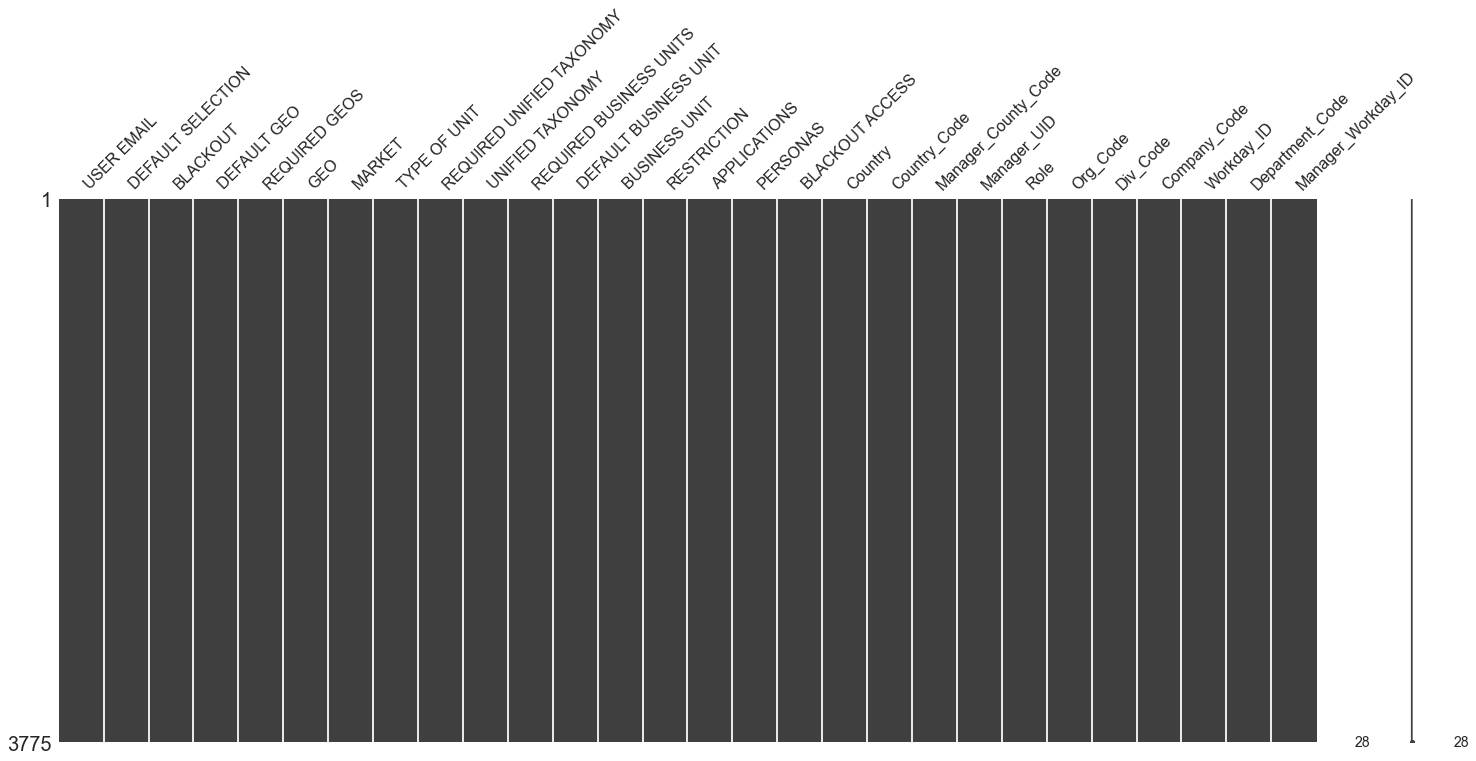

In [35]:
msno.matrix(dataset)
plt.show()

#### Phase 3
#### Employee Working Region
- IOT

In [36]:
def extract_bluepage_data(email):
    IOT = None
    base_url = bluepage_api_url = "https://unified-profile-api.us-south-k8s.intranet.ibm.com/v3/profiles/{}/profile".format(email)
    response = requests.get(base_url)
    if response.status_code != 200:
        time.sleep(5)
        return None
    try:
        results = response.json()['content']
        IOT = results['iot']
         
    except:
        pass
    return IOT

def enrich_dataset(dataset):
    column_name = 'USER EMAIL' # the name of the column in the dataset where it has email addresses.
    email_value = dataset[column_name]
    IOT = extract_bluepage_data(email_value)
    dataset['IOT'] = IOT
    return dataset

print(datetime.now())

2021-08-19 12:55:15.434832


#### Dropping the missing values

#### Dropping the duplicated rows

### Save Dataset (Phase 3): Enriched, No Missing Values, No Duplicated Data

In [37]:
dataset = pd.read_csv('Data_Original_Cleaned_Enriched-e_Enriched-m_Enriched-iot.csv')
dataset.shape

(3774, 29)

In [38]:
eda(dataset)

Features  Duplicated Values  Duplicated Rows  \
0                  USER EMAIL                 13                0   
1           DEFAULT SELECTION               3772                0   
2                    BLACKOUT               3772                0   
3                 DEFAULT GEO               3769                0   
4               REQUIRED GEOS               3767                0   
5                         GEO               3741                0   
6                      MARKET               3749                0   
7                TYPE OF UNIT               3772                0   
8   REQUIRED UNIFIED TAXONOMY               3771                0   
9            UNIFIED TAXONOMY               3752                0   
10    REQUIRED BUSINESS UNITS               3767                0   
11      DEFAULT BUSINESS UNIT               3765                0   
12              BUSINESS UNIT               3632                0   
13                RESTRICTION               3768                0   
14               APPLICATIONS               3755                0   
15                   PERSONAS               3723                0   
16            BLACKOUT ACCESS               3754                0   
17                    Country               3706                0   
18               Country_Code               3702                0   
19        Manager_County_Code               3706                0   
20                Manager_UID               2410                0   
21                       Role                435                0   
22                   Org_Code               3567                0   
23                   Div_Code               3680                0   
24               Company_Code               3673                0   
25                 Workday_ID                 24                0   
26            Department_Code               2234                0   
27         Manager_Workday_ID               2410                0   
28                        IOT               3770                0   

    Missing Values  Unique Values Data Type  
0                0           3761    object  
1                0              2    object  
2                0              2    object  
3                0              5    object  
4                0              7    object  
5                0             33    object  
6                0             25    object  
7                0              2    object  
8                0              3    object  
9                0             22    object  
10               0              7    object  
11               0              9    object  
12               0            142    object  
13               0              6    object  
14               0             19    object  
15               0             51    object  
16               0             20    object  
17               0             68    object  
18               0             72    object  
19               0             68    object  
20               0           1364    object  
21               0           3339    object  
22               0            207    object  
23               0             94    object  
24               0            101     int64  
25               0           3750     int64  
26               0           1540    object  
27               0           1364     int64  
28               0              4    object

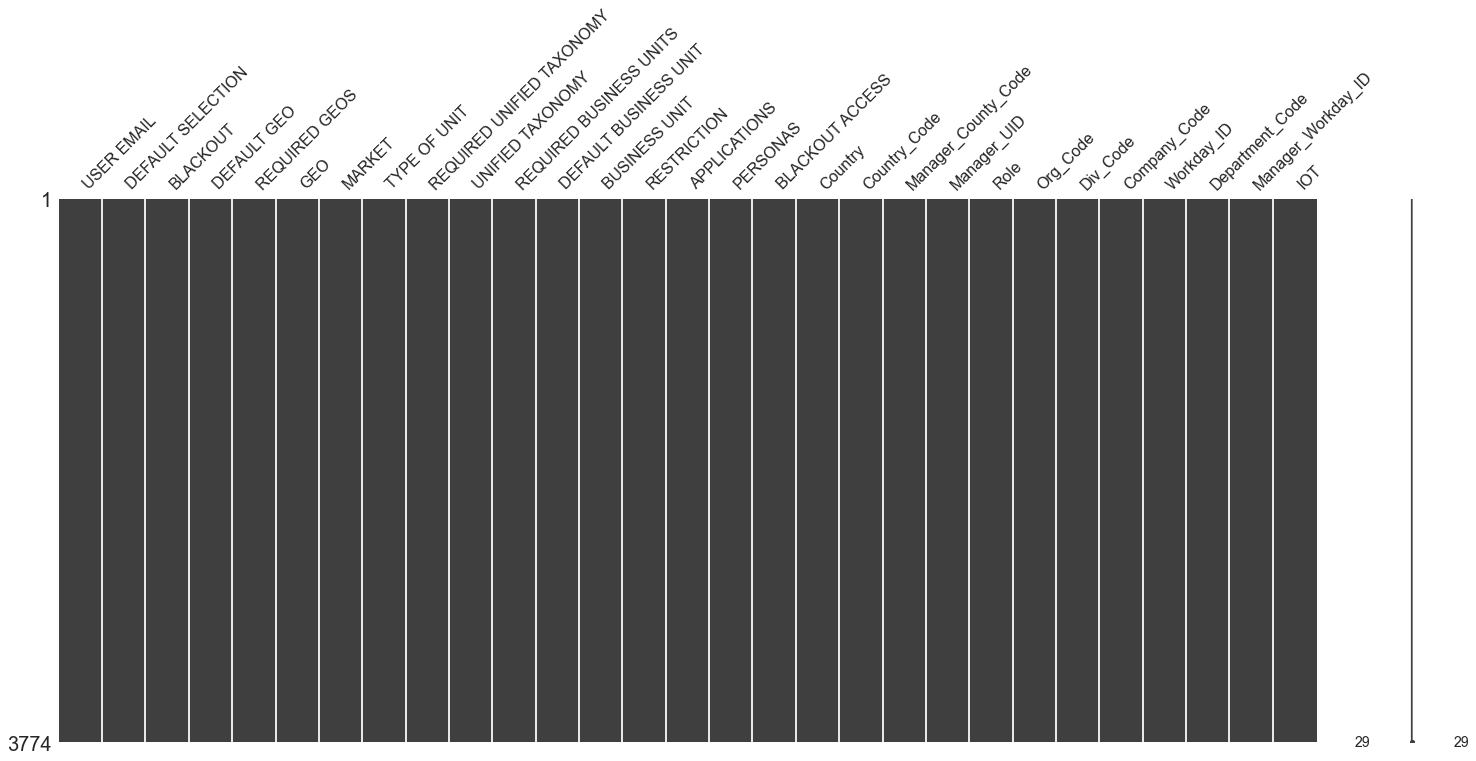

In [39]:
msno.matrix(dataset)
plt.show()

### User Common Attribute - Country

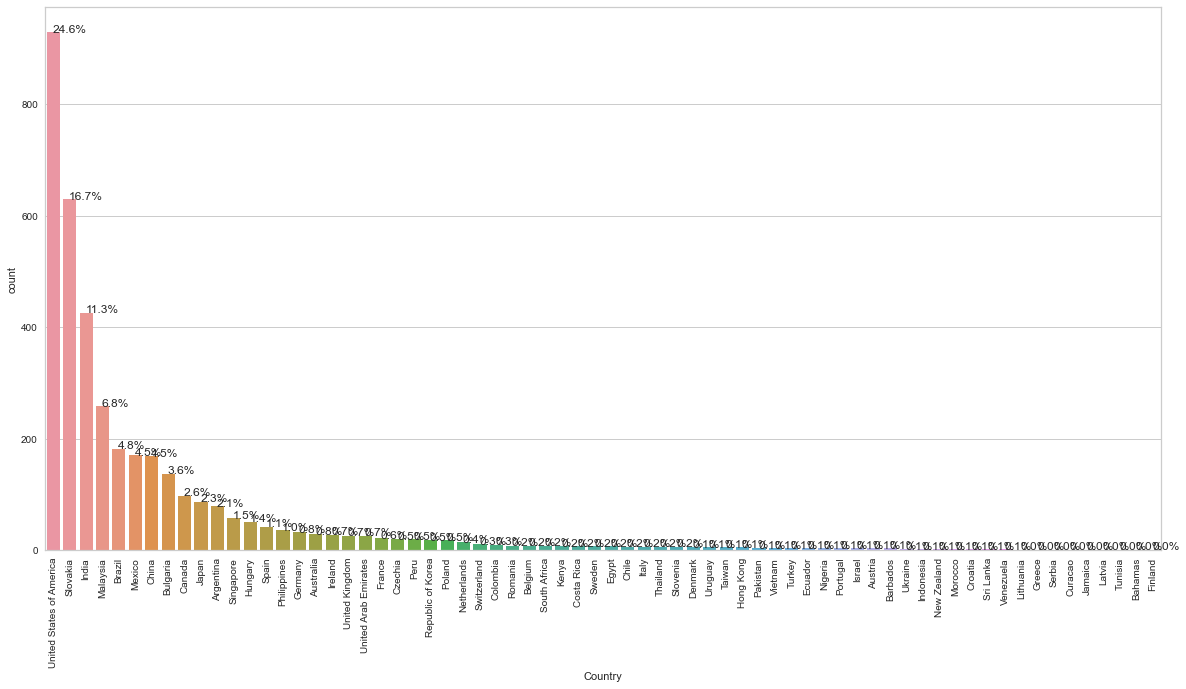

In [40]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset.Country, order=dataset['Country'].value_counts().index)
perc_on_bar(ax, dataset.Country)

### User Common Attribute - IOT (Region)

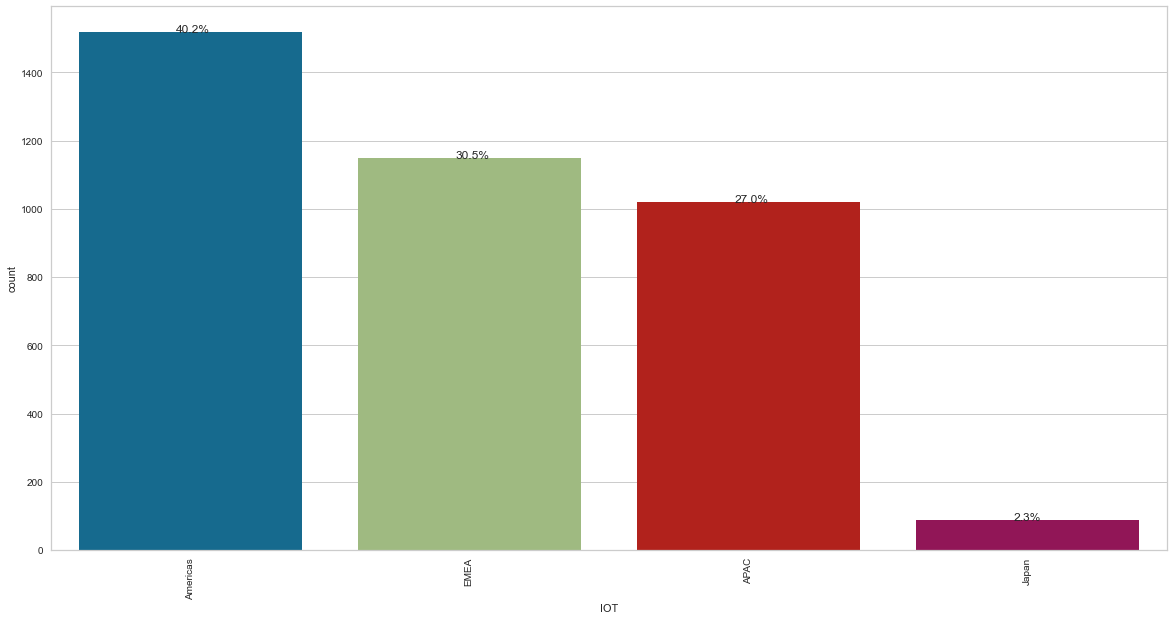

In [41]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset.IOT, order=dataset['IOT'].value_counts().index)
perc_on_bar(ax, dataset.IOT)

### Feature-Engineering

#### There are multiple values in GEO, BUSINESS UNIT, BLACKOUT, PERSONAS and APPLICATION (Target) columns that need to be exported.

In [42]:
geo_cols = {'JAPAN': 'GEO_JAPAN', 
            'AMERICAS': 'GEO_AMERICAS', 
            'EMEA': 'GEO_EMEA', 
            'APAC': 'GEO_APAC',
            'All Geos': 'GEO_All_Geos', 
            'Worldwide': 'GEO_Worldwide'}

bu_cols = {'Cloud and Cognitive Software': 'BU_CLOUD_COGNITIVE_SOFTWARE',
           'Corp HQ Above Business Unit': 'BU_CORP_HQ',
           'All Business Units': 'BU_ALL_BU',
           'IBM Systems': 'BU_IBM_SYSTEMS',
           'Total IBM': 'BU_TOTAL_IBM',
           'GTS Dual': 'BU_GTS_DUAL',
           'GBS': 'BU_GBS', 
           'IGF': 'BU_IGF'}

blackout_cols = {'WWConsol:Blackout': 'BLACKOUT_WWCON', 
                 'WWBalsht:Blackout': 'BLACKOUT_WWBAL', 
                 'WWGID:Blackout': 'BLACKOUT_WWGID'}

persona_cols = {'WWBalsht:Planner - Read/Write': 'PER_WWBAL_RW', 
                'WWConsol:Planner - Read/Write': 'PER_WWCON_RW', 
                'WWGID:Planner - Read/Write': 'PER_WWGID_RW', 
                'Cash IQ:Analyst - Read': 'PER_CASHIQ_R', 
                'WWGID:Analyst - Read': 'PER_WWGID_R', 
                'WWPen:Planner - Read/Write': 'PER_WWPEN_RW', 
                'WWConsol:Analyst - Read': 'PER_WWCON_R', 
                'WWBalsht:Analyst - Read': 'PER_WWBAL_R',
                'WWGID:BPO Rep': 'PER_WWGID_BPO'}

app_cols = {'WWConsol': 'APP_WWCONSOL',
            'WWGID': 'APP_WWGID',
            'WWBalsht': 'APP_WWBALSHT',
            'Cash IQ': 'APP_CASHIQ'}

ut_cols = {'Cognitive Applications': 'UT_Cognitive_Applications',
           'Cloud and Data Platform': 'UT_Cloud_Data_Platform',
           'Watson Health': 'UT_Watson_Health',
           'IBM Systems': 'UT_IBM_Systems',
           'Security': 'UT_Security',
           'GBS': 'UT_GBS',
           'IGF': 'UT_IGF',
           'GTS': 'UT_GTS'}

#### One-Hot Encoding

In [43]:
for i in dataset.index:

    curr_geo = dataset['GEO'][i]
    for geo in geo_cols.keys():
        key = geo_cols[geo]
        if geo in curr_geo: dataset.at[i, key] = 1
        else: dataset.at[i, key] = 0

    curr_bu = dataset['BUSINESS UNIT'][i]
    for bu in bu_cols:
        key = bu_cols[bu]
        if bu in curr_bu: dataset.at[i, key] = 1
        else: dataset.at[i, key] = 0
            
    curr_blackout = dataset['BLACKOUT ACCESS'][i]
    for access in blackout_cols:
        key = blackout_cols[access]
        if access in curr_blackout: dataset.at[i, key] = 1
        else: dataset.at[i, key] = 0
            
    curr_persona = dataset['PERSONAS'][i]
    for per in persona_cols:
        key = persona_cols[per]
        if per in curr_persona: dataset.at[i, key] = 1
        else: dataset.at[i, key] = 0
            
    curr_app = dataset['APPLICATIONS'][i]
    for app in app_cols:
        key = app_cols[app]
        if app in curr_app: dataset.at[i, key] = 1
        else: dataset.at[i, key] = 0
            
    curr_ut = dataset['UNIFIED TAXONOMY'][i]
    for ut in ut_cols:
        key = ut_cols[ut]
        if ut in curr_ut: dataset.at[i, key] = 1
        else: dataset.at[i, key] = 0

#### IOT - Ordinal Encoding

In [44]:
dataset['IOT'].unique()

array(['Japan', 'Americas', 'APAC', 'EMEA'], dtype=object)

In [45]:
dataset['IOT'] = dataset['IOT'].replace(['Americas','Japan','EMEA','APAC'],[1,2,3,4])

#### BLACKOUT - Get Dummies (One-Hot Encoding)

In [46]:
dataset = pd.get_dummies(dataset, columns=['BLACKOUT'], drop_first=True)
dataset = dataset.rename(columns={"BLACKOUT_YES": "BLACKOUT"})

### Save Dataset: Enriched, No Missing Values, No Duplicated Data, Encoded

In [47]:
dataset.to_csv('Data_Original_Enriched_Nomissing_Noduplicate_Encoded.csv', index=False, header=True)

In [48]:
dataset = pd.read_csv('Data_Original_Enriched_Nomissing_Noduplicate_Encoded.csv')
dataset.shape

(3774, 67)

In [49]:
eda(dataset)

Features  Duplicated Values  Duplicated Rows  Missing Values  \
0          USER EMAIL                 13                0               0   
1   DEFAULT SELECTION               3772                0               0   
2         DEFAULT GEO               3769                0               0   
3       REQUIRED GEOS               3767                0               0   
4                 GEO               3741                0               0   
..                ...                ...              ...             ...   
62        UT_Security               3772                0               0   
63             UT_GBS               3772                0               0   
64             UT_IGF               3772                0               0   
65             UT_GTS               3772                0               0   
66           BLACKOUT               3772                0               0   

    Unique Values Data Type  
0            3761    object  
1               2    object  
2               5    object  
3               7    object  
4              33    object  
..            ...       ...  
62              2   float64  
63              2   float64  
64              2   float64  
65              2   float64  
66              2     int64  

[67 rows x 6 columns]

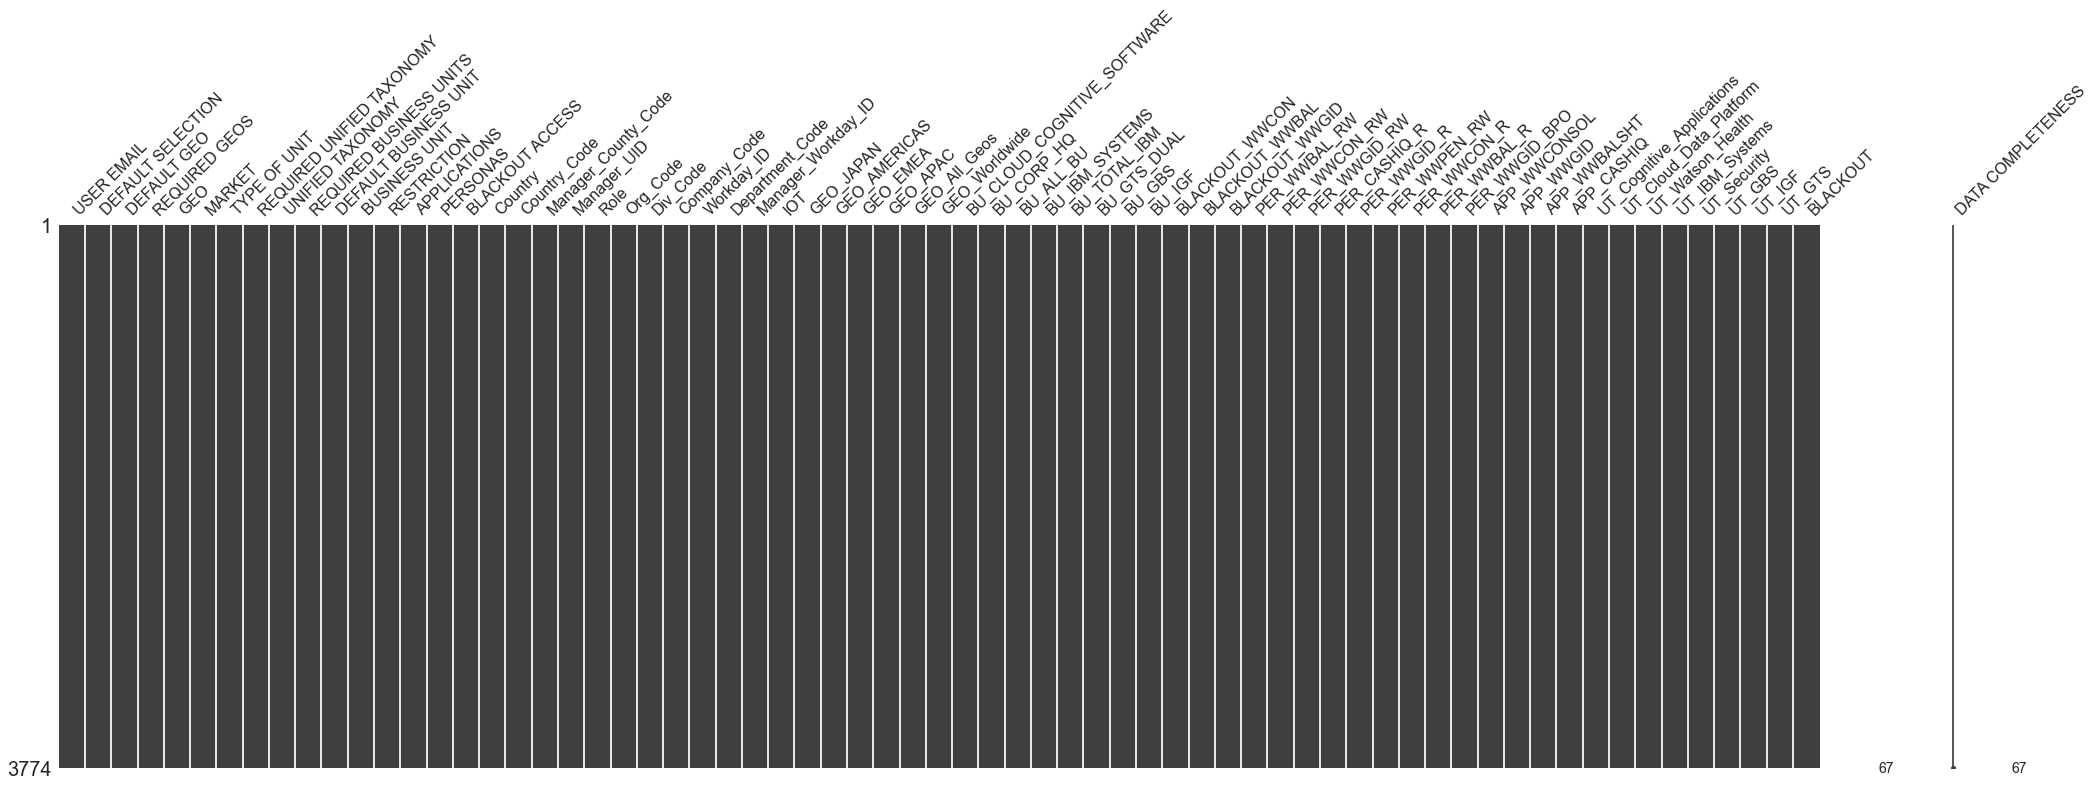

In [50]:
msno.matrix(dataset, labels=True, figsize=(35, 10))
plt.show()

#### Sorting the cell values of the columns with multiple values

In [51]:
for i in dataset.index:
    row = dataset.loc[i]
    geos = []
    bus = []
    accs = []
    pers = []
    apps = []
    ut = []
    
    '''
    Iterate through each encoded column; if the value is 1, add the corresponding name (e.g. "AMERICAS") to the GEO label
    
    Each GEO is separated by a ', ' in the label
    '''
    
    for key in geo_cols:
        val = geo_cols[key]
        if dataset.at[i, val]: geos.append(key)
    dataset.at[i, 'GEO'] = ', '.join(geos)
    
    for key in bu_cols:
        val = bu_cols[key]
        if dataset.at[i, val]: bus.append(key)
    dataset.at[i, 'BUSINESS UNIT'] = ', '.join(bus)
    
    for key in persona_cols:
        val = persona_cols[key]
        if dataset.at[i, val]: pers.append(key)
    dataset.at[i, 'PERSONAS'] = ', '.join(pers)
    
    for key in blackout_cols:
        val = blackout_cols[key]
        if dataset.at[i, val]: accs.append(key)
    dataset.at[i, 'BLACKOUT ACCESS'] = ', '.join(accs)
    
    for key in app_cols:
        val = app_cols[key]
        if dataset.at[i, val]: apps.append(key)
    dataset.at[i, 'APPLICATIONS'] = ', '.join(apps)
    
    for key in ut_cols:
        val = ut_cols[key]
        if dataset.at[i, val]: ut.append(key)
    dataset.at[i, 'UNIFIED TAXONOMY'] = ', '.join(ut)

### Save Dataset: Enriched, No Missing Values, No Duplicated Data, Encoded, Sorted

In [52]:
dataset.to_csv('Data_Original_Enriched_Nomissing_Noduplicate_Encoded_Sorted.csv', index=False, header=True)

In [53]:
dataset = pd.read_csv('Data_Original_Enriched_Nomissing_Noduplicate_Encoded_Sorted.csv')
dataset.shape

(3774, 67)

In [54]:
eda(dataset)

Features  Duplicated Values  Duplicated Rows  Missing Values  \
0          USER EMAIL                 13                0               0   
1   DEFAULT SELECTION               3772                0               0   
2         DEFAULT GEO               3769                0               0   
3       REQUIRED GEOS               3767                0               0   
4                 GEO               3759                0             240   
..                ...                ...              ...             ...   
62        UT_Security               3772                0               0   
63             UT_GBS               3772                0               0   
64             UT_IGF               3772                0               0   
65             UT_GTS               3772                0               0   
66           BLACKOUT               3772                0               0   

    Unique Values Data Type  
0            3761    object  
1               2    object  
2               5    object  
3               7    object  
4              14    object  
..            ...       ...  
62              2   float64  
63              2   float64  
64              2   float64  
65              2   float64  
66              2     int64  

[67 rows x 6 columns]

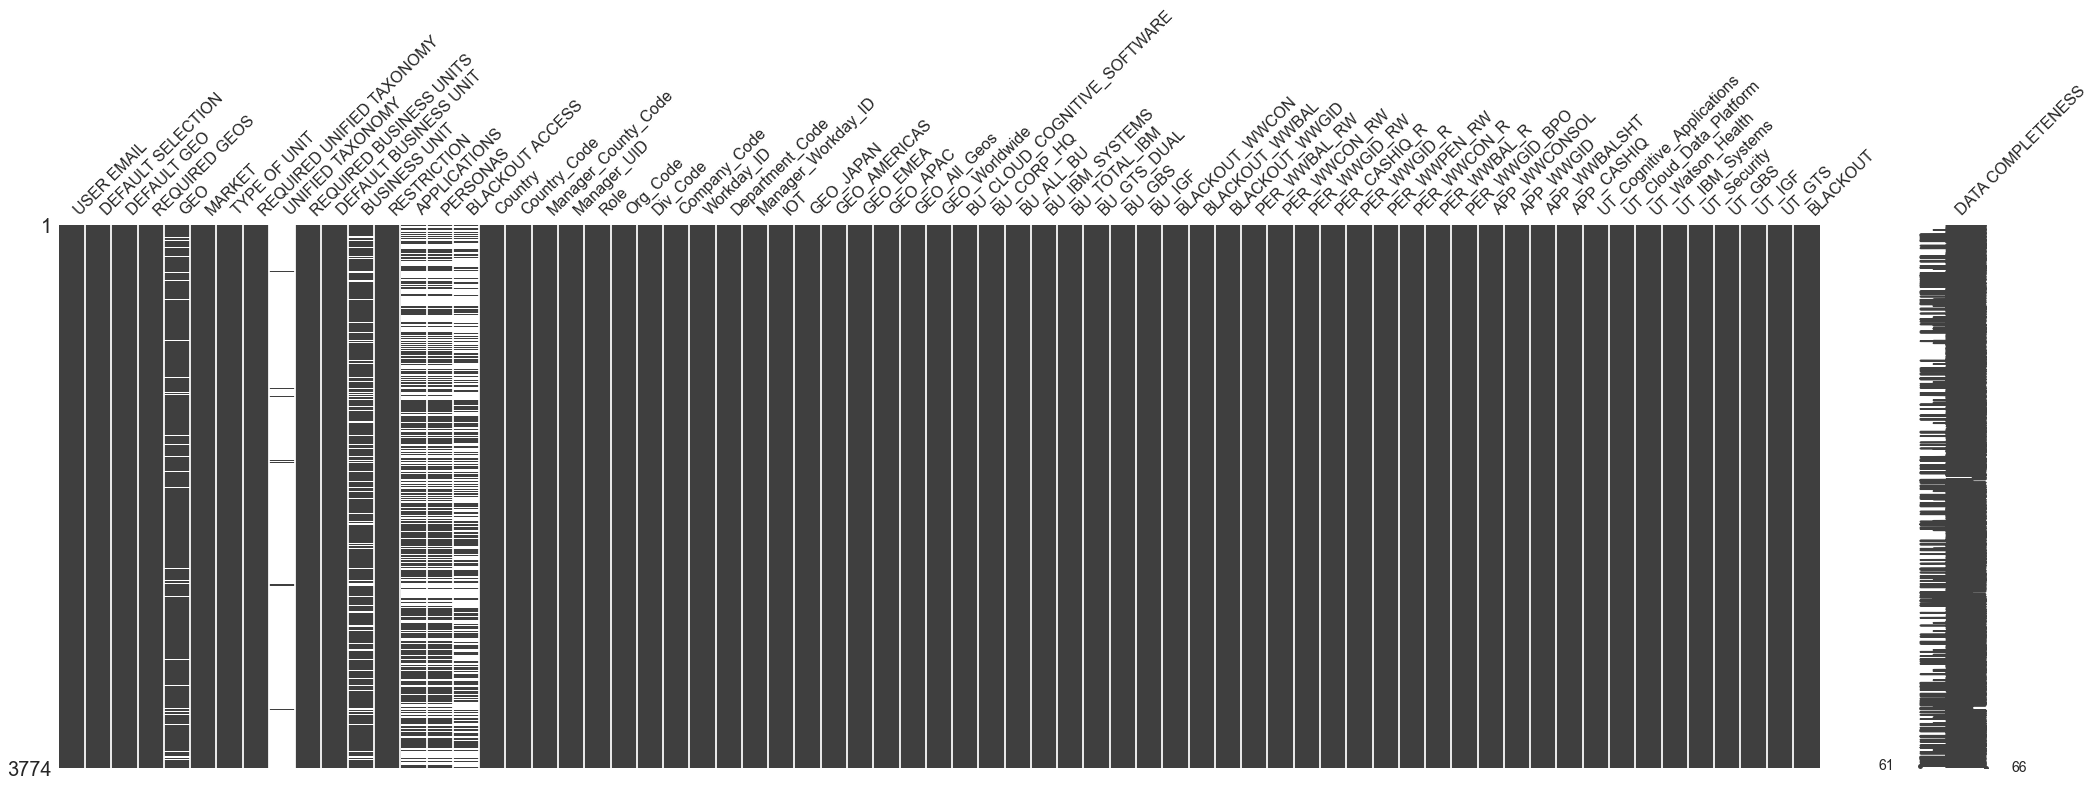

In [55]:
msno.matrix(dataset, labels=True, figsize=(35, 10))
plt.show()

#### GEO

In [56]:
print ('\n','Number of unique values:', dataset['GEO'].nunique(),
       '\n','Unique values:','\n',dataset['GEO'].unique())


 Number of unique values: 14 
 Unique values: 
 ['JAPAN' 'AMERICAS' 'Worldwide' 'EMEA' 'All Geos' 'APAC' 'EMEA, APAC'
 'AMERICAS, EMEA' 'JAPAN, AMERICAS, EMEA, APAC' nan 'JAPAN, APAC'
 'AMERICAS, EMEA, APAC' 'AMERICAS, APAC' 'JAPAN, EMEA, APAC'
 'JAPAN, AMERICAS, EMEA']


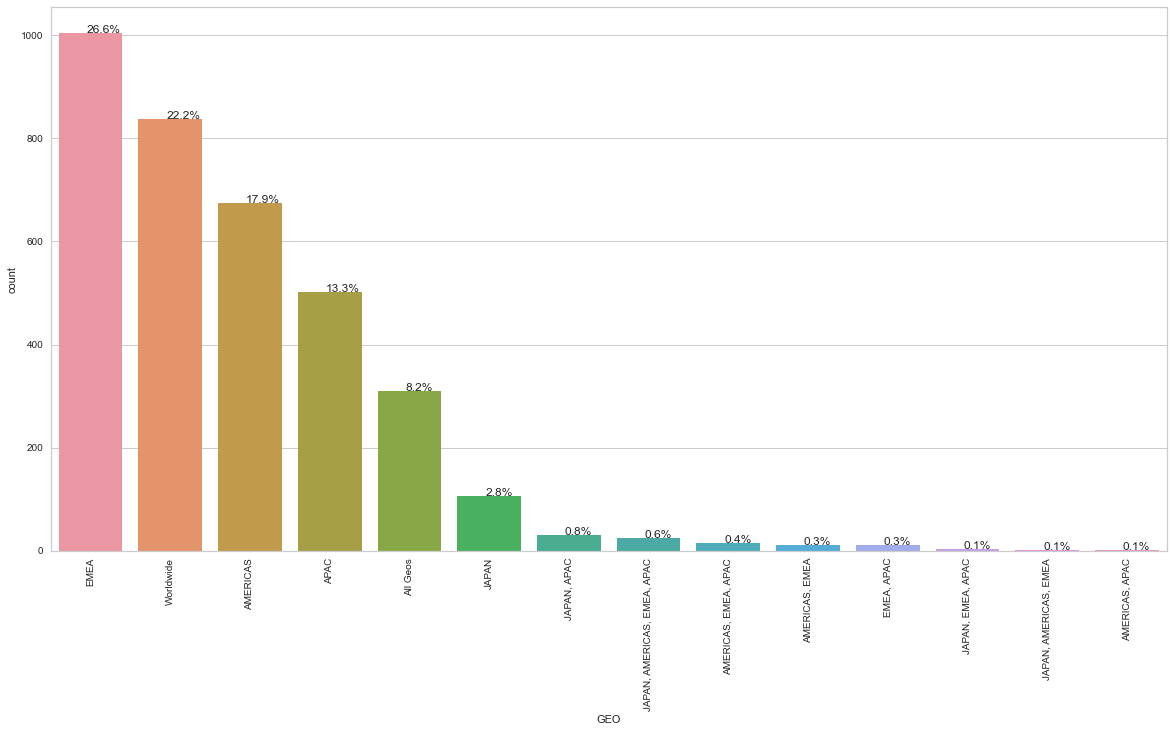

In [57]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset.GEO, order=dataset['GEO'].value_counts().index)
perc_on_bar(ax, dataset.GEO)

#### UNIFIED TAXONOMY

In [58]:
print ('\n','Number of unique values:', dataset['UNIFIED TAXONOMY'].nunique(),
       '\n','Unique values:','\n',dataset['UNIFIED TAXONOMY'].unique())


 Number of unique values: 17 
 Unique values: 
 [nan 'Cloud and Data Platform'
 'Cognitive Applications, Cloud and Data Platform, Watson Health, Security'
 'Cognitive Applications, Cloud and Data Platform' 'GBS'
 'Cognitive Applications, Cloud and Data Platform, Watson Health, IBM Systems, Security'
 'GTS'
 'Cognitive Applications, Cloud and Data Platform, Watson Health, IBM Systems, Security, GBS, IGF, GTS'
 'Cloud and Data Platform, Watson Health, IBM Systems, GTS' 'GBS, GTS'
 'IBM Systems' 'Cloud and Data Platform, IBM Systems, Security, GBS, GTS'
 'Cognitive Applications, Cloud and Data Platform, GBS, GTS' 'Security'
 'Cognitive Applications' 'Cloud and Data Platform, IBM Systems'
 'Cognitive Applications, Cloud and Data Platform, Watson Health, IBM Systems, Security, GBS, IGF'
 'Cognitive Applications, Cloud and Data Platform, Watson Health, Security, GBS, GTS']


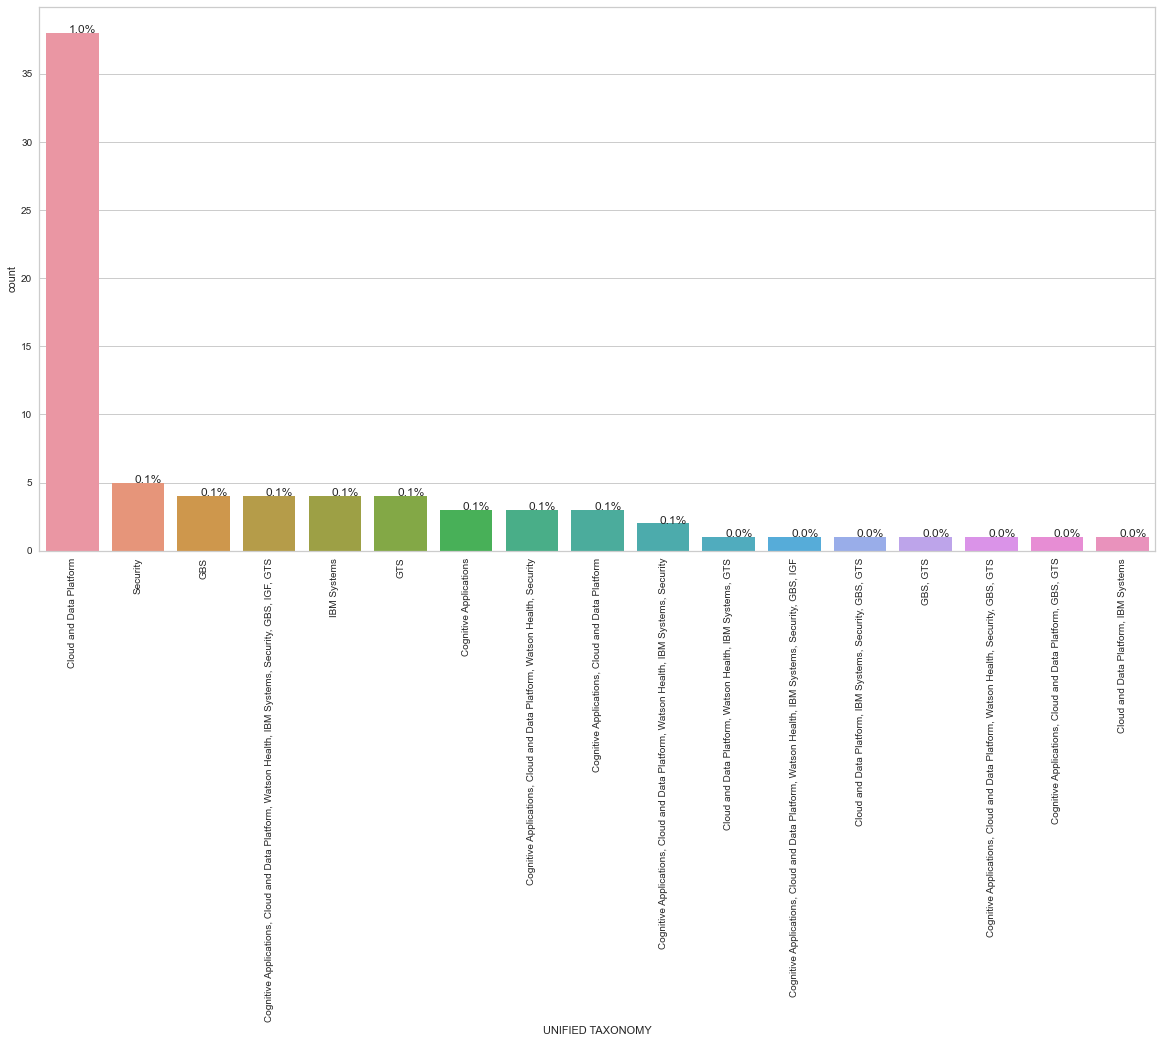

In [59]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset['UNIFIED TAXONOMY'], order=dataset['UNIFIED TAXONOMY'].value_counts().index)
perc_on_bar(ax, dataset['UNIFIED TAXONOMY'])

#### BUSINESS UNIT

In [60]:
print ('\n','Number of unique values:', dataset['BUSINESS UNIT'].nunique(),
       '\n','Unique values:','\n',dataset['BUSINESS UNIT'].unique())


 Number of unique values: 38 
 Unique values: 
 ['GBS' 'Cloud and Cognitive Software, IBM Systems, GTS Dual'
 'Cloud and Cognitive Software, GTS Dual' 'GTS Dual'
 'Corp HQ Above Business Unit' 'GTS Dual, GBS' 'All Business Units'
 'Cloud and Cognitive Software' nan 'Total IBM' 'IBM Systems'
 'Cloud and Cognitive Software, IBM Systems, GTS Dual, GBS'
 'Cloud and Cognitive Software, IBM Systems' 'IBM Systems, GBS'
 'IBM Systems, GTS Dual' 'IGF' 'Corp HQ Above Business Unit, GBS'
 'Cloud and Cognitive Software, GTS Dual, GBS'
 'Corp HQ Above Business Unit, GTS Dual'
 'Corp HQ Above Business Unit, GTS Dual, GBS'
 'Cloud and Cognitive Software, GBS'
 'Cloud and Cognitive Software, Corp HQ Above Business Unit, IBM Systems'
 'Cloud and Cognitive Software, Corp HQ Above Business Unit, GTS Dual'
 'Corp HQ Above Business Unit, IBM Systems'
 'Cloud and Cognitive Software, Corp HQ Above Business Unit, IBM Systems, GTS Dual, IGF'
 'Cloud and Cognitive Software, IBM Systems, GTS Dual, GBS, IGF'
 'C

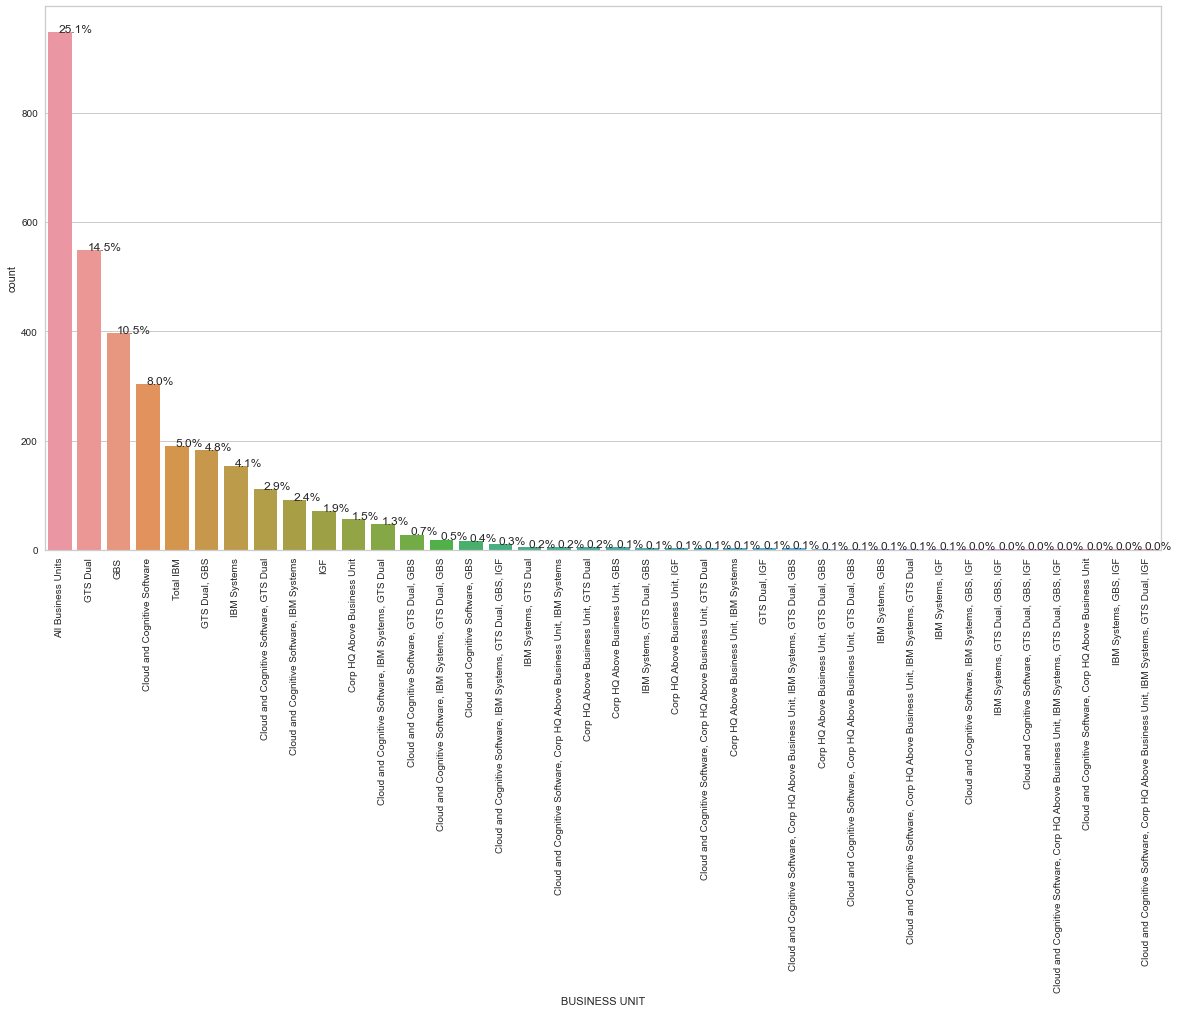

In [61]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset['BUSINESS UNIT'], order=dataset['BUSINESS UNIT'].value_counts().index)
perc_on_bar(ax, dataset['BUSINESS UNIT'])

#### Insights:
- 25.5% of users select ALL BUSINESS UNITS
- 14.5% of users select GTS DUAL
- 9.7% of users select ALL GBS
- 8% of users select CLOUD AND COGNITIVE SOFTWARE
- 5.1% of users select TOTAL IBM
- 4.5% of users select IBM SYSTEMS
- 1.8% of users select IGF

#### 69.1% of users select single business unit

#### APPLICATIONS

In [62]:
print ('\n','Number of unique values:', dataset['APPLICATIONS'].nunique(),
       '\n','Unique values:','\n',dataset['APPLICATIONS'].unique())


 Number of unique values: 10 
 Unique values: 
 ['WWConsol' nan 'WWBalsht' 'WWConsol, WWBalsht'
 'WWConsol, WWGID, WWBalsht' 'WWConsol, WWGID' 'WWGID' 'Cash IQ'
 'WWGID, WWBalsht' 'WWConsol, WWBalsht, Cash IQ'
 'WWConsol, WWGID, WWBalsht, Cash IQ']


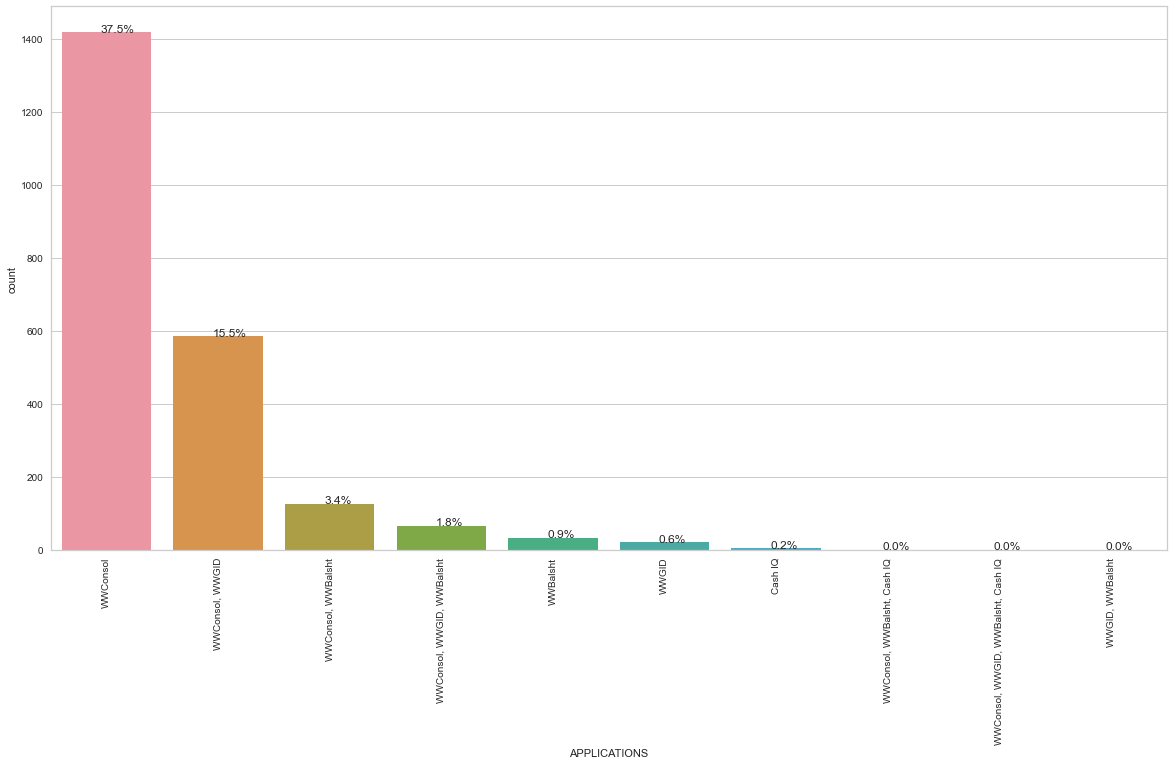

In [63]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset['APPLICATIONS'], order=dataset['APPLICATIONS'].value_counts().index)
perc_on_bar(ax, dataset['APPLICATIONS'])

#### PERSONAS

In [64]:
print ('Number of unique values:', dataset['PERSONAS'].nunique())

Number of unique values: 30


In [65]:
for value in dataset['PERSONAS'].unique():
    print (value, '\t')

WWConsol:Analyst - Read 	
nan 	
WWBalsht:Analyst - Read 	
WWConsol:Analyst - Read, WWBalsht:Analyst - Read 	
WWConsol:Planner - Read/Write 	
WWGID:Planner - Read/Write, WWConsol:Analyst - Read, WWBalsht:Analyst - Read 	
WWGID:Analyst - Read, WWConsol:Analyst - Read 	
WWConsol:Planner - Read/Write, WWGID:Planner - Read/Write 	
WWConsol:Planner - Read/Write, WWGID:Analyst - Read 	
WWConsol:Planner - Read/Write, WWBalsht:Analyst - Read 	
WWGID:Analyst - Read 	
WWGID:Analyst - Read, WWConsol:Analyst - Read, WWBalsht:Analyst - Read 	
WWConsol:Planner - Read/Write, WWGID:Planner - Read/Write, WWBalsht:Analyst - Read 	
WWBalsht:Planner - Read/Write, WWConsol:Planner - Read/Write, WWGID:Planner - Read/Write 	
WWBalsht:Planner - Read/Write, WWConsol:Analyst - Read 	
WWBalsht:Planner - Read/Write, WWConsol:Planner - Read/Write, WWGID:Analyst - Read 	
WWBalsht:Planner - Read/Write, WWConsol:Planner - Read/Write 	
WWGID:Planner - Read/Write, WWConsol:Analyst - Read 	
WWBalsht:Planner - Read/Write 

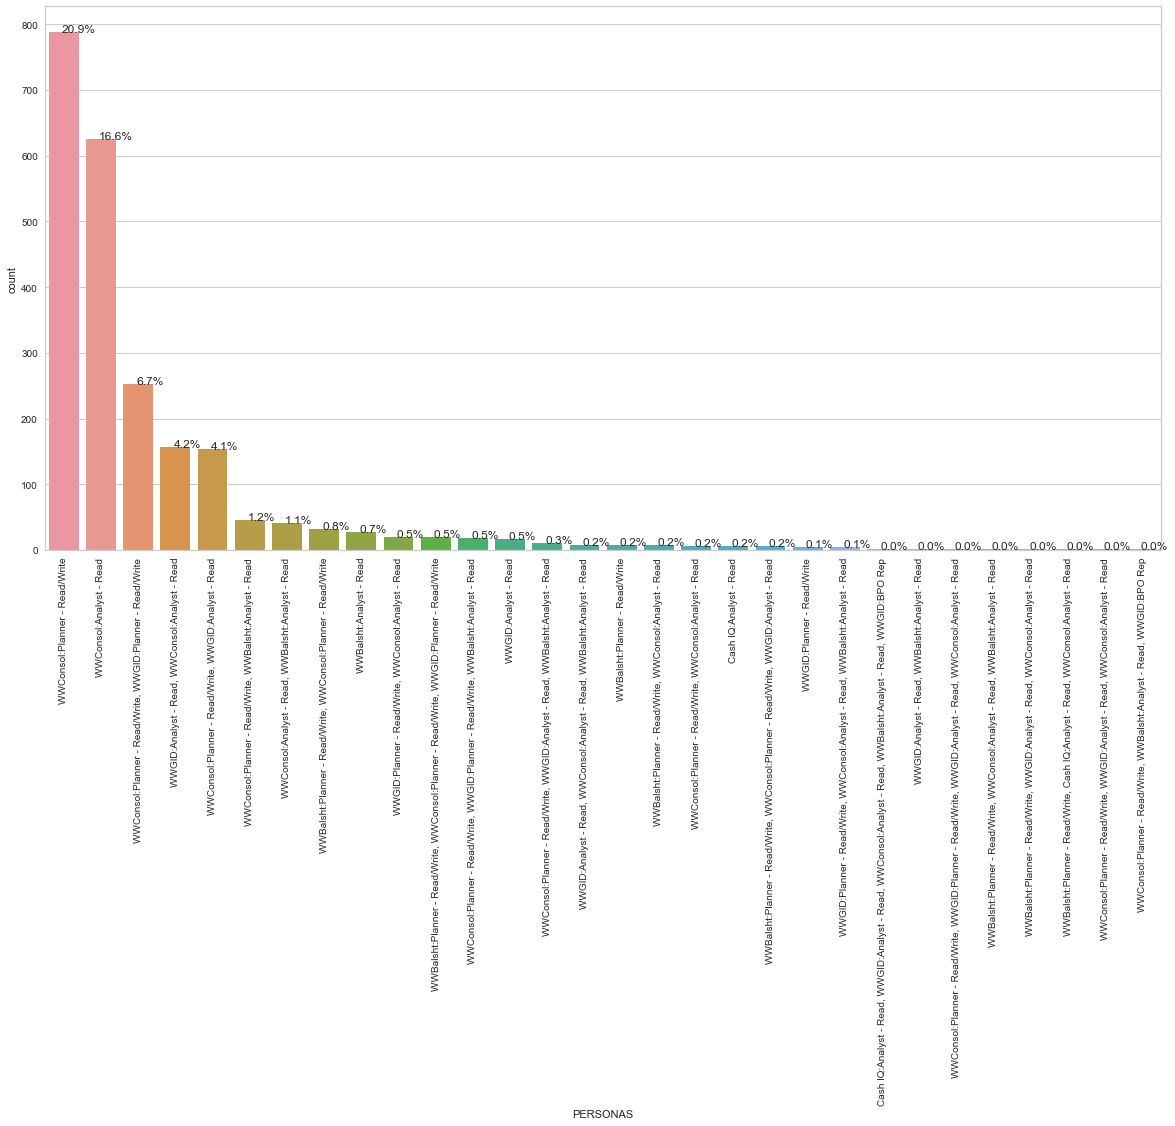

In [66]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset['PERSONAS'], order=dataset['PERSONAS'].value_counts().index)
perc_on_bar(ax, dataset['PERSONAS'])

#### BLACKOUT ACCESS

In [67]:
print ('\n','Number of unique values:', dataset['BLACKOUT ACCESS'].nunique(),
       '\n','Unique values:', '\n',dataset['BLACKOUT ACCESS'].unique())


 Number of unique values: 7 
 Unique values: 
 ['WWConsol:Blackout' nan 'WWConsol:Blackout, WWBalsht:Blackout'
 'WWConsol:Blackout, WWBalsht:Blackout, WWGID:Blackout'
 'WWConsol:Blackout, WWGID:Blackout' 'WWGID:Blackout'
 'WWBalsht:Blackout, WWGID:Blackout' 'WWBalsht:Blackout']


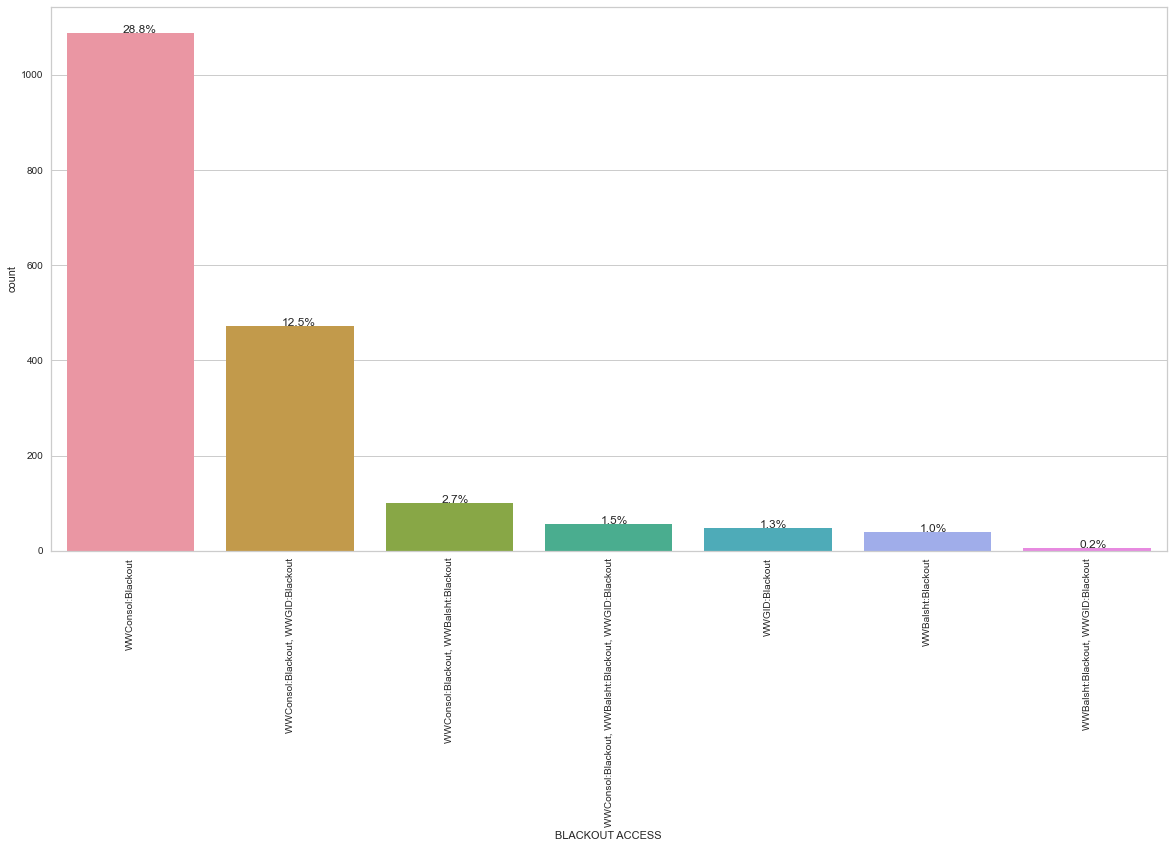

In [68]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
ax = sns.countplot(dataset['BLACKOUT ACCESS'], order=dataset['BLACKOUT ACCESS'].value_counts().index)
perc_on_bar(ax, dataset['BLACKOUT ACCESS'])

### Save Dataset: Enriched, No Missing Values, No Duplicated Data, Encoded, Sorted, Ready

In [69]:
dataset.to_csv('Data_Original_Enriched_Nomissing_Noduplicate_Encoded_Sorted.csv', index=False, header=True)

In [70]:
dataset = pd.read_csv('Data_Original_Enriched_Nomissing_Noduplicate_Encoded_Sorted.csv')
dataset.shape

(3774, 67)

### Bivariate Analysis

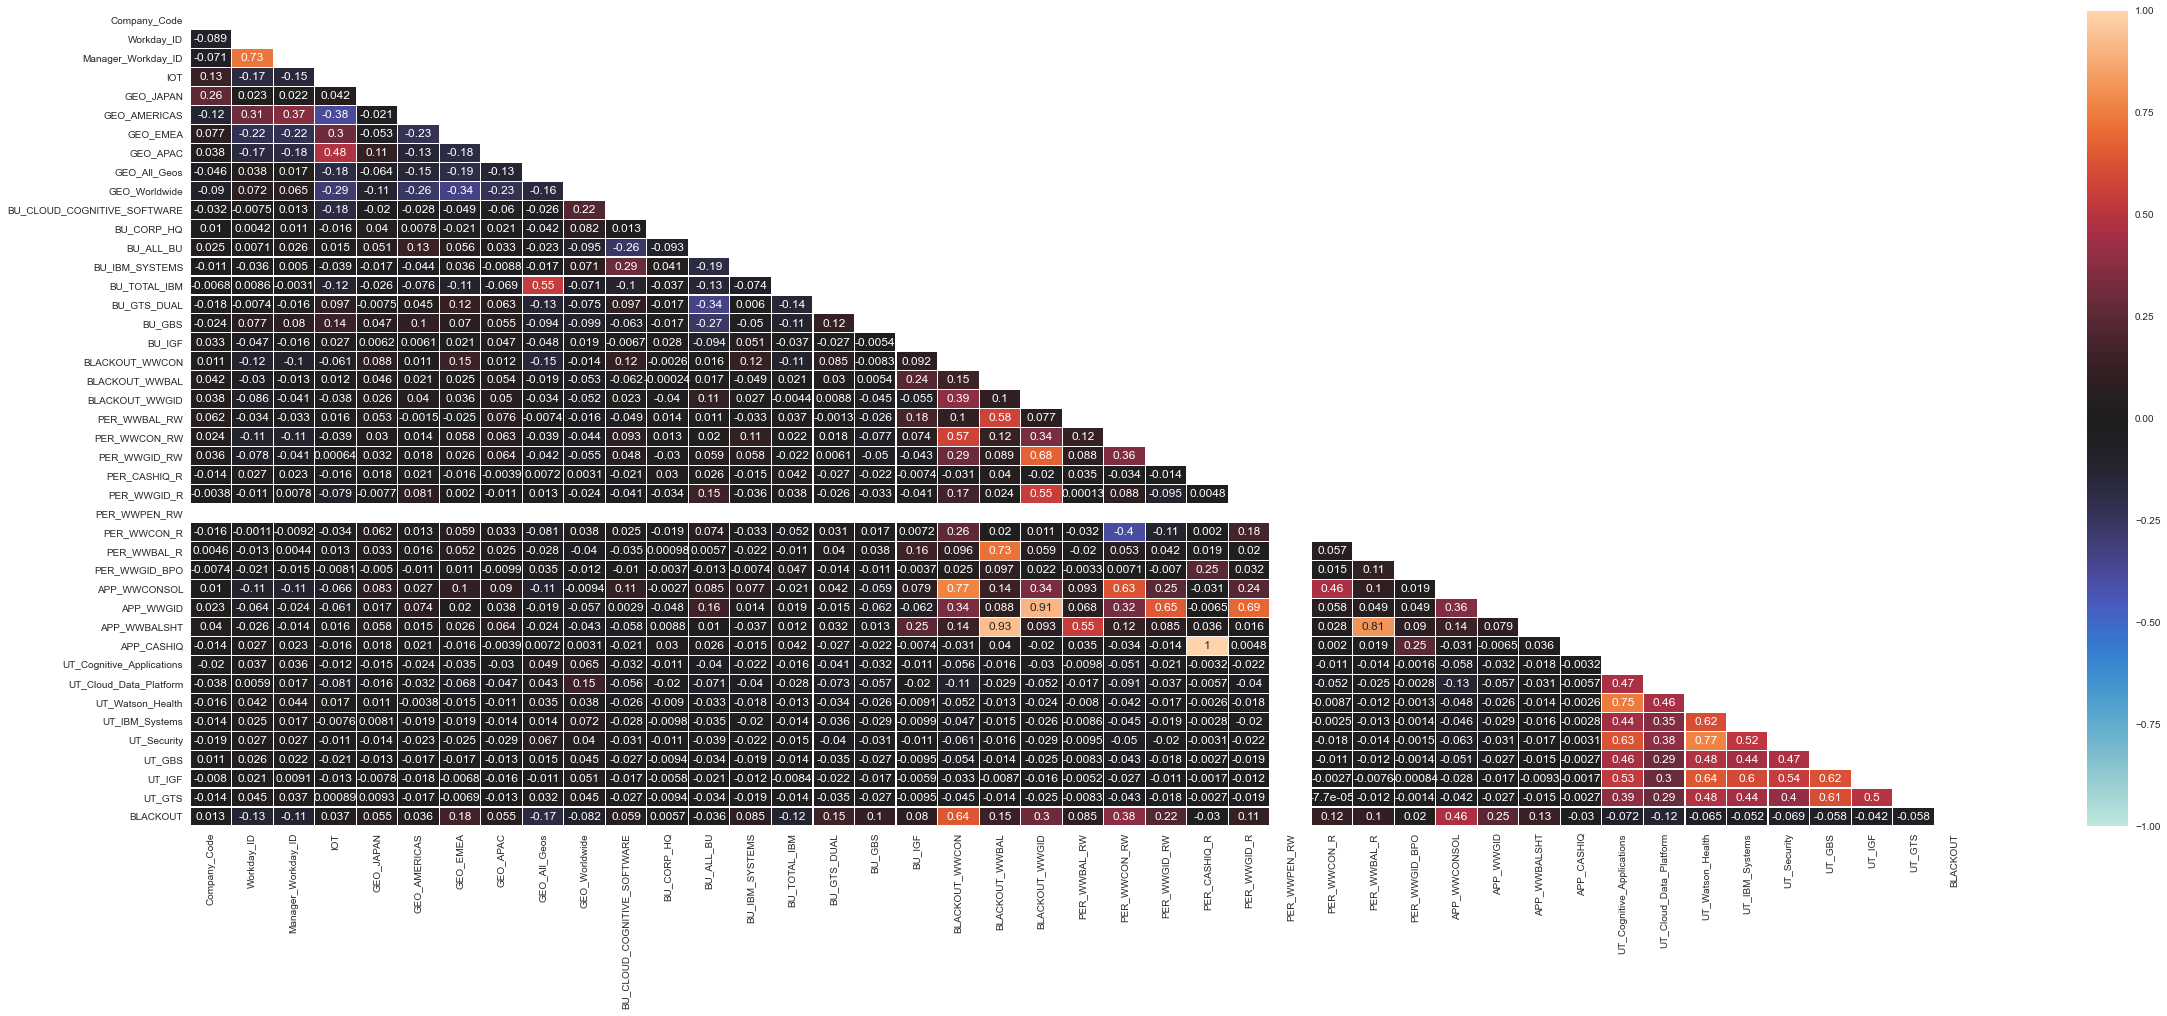

In [71]:
plt.figure(figsize=(40,15))
mask = np.triu(np.ones_like(dataset.corr(), dtype=bool))
sns.heatmap(dataset.corr(),
            annot=True,
            linewidths=0.1,vmin=-1,vmax=1,
            center=0,
            cbar=True,
            mask=mask,)            

plt.show()

### Making the dataset ready for modeling

### Feature Reduction

##### Dropping the column non numerical values

In [72]:
dataset = dataset.drop(columns=['USER EMAIL',
 'DEFAULT SELECTION',
 'DEFAULT GEO',
 'REQUIRED GEOS',
 'GEO',
 'MARKET',
 'TYPE OF UNIT',
 'REQUIRED UNIFIED TAXONOMY',
 'UNIFIED TAXONOMY',
 'REQUIRED BUSINESS UNITS',
 'DEFAULT BUSINESS UNIT',
 'BUSINESS UNIT',
 'RESTRICTION',
 'APPLICATIONS',
 'PERSONAS',
 'BLACKOUT ACCESS',
 'Country',
 'Manager_UID',
 'Role',
 'Workday_ID',
 'Department_Code'])
dataset.shape

(3774, 46)

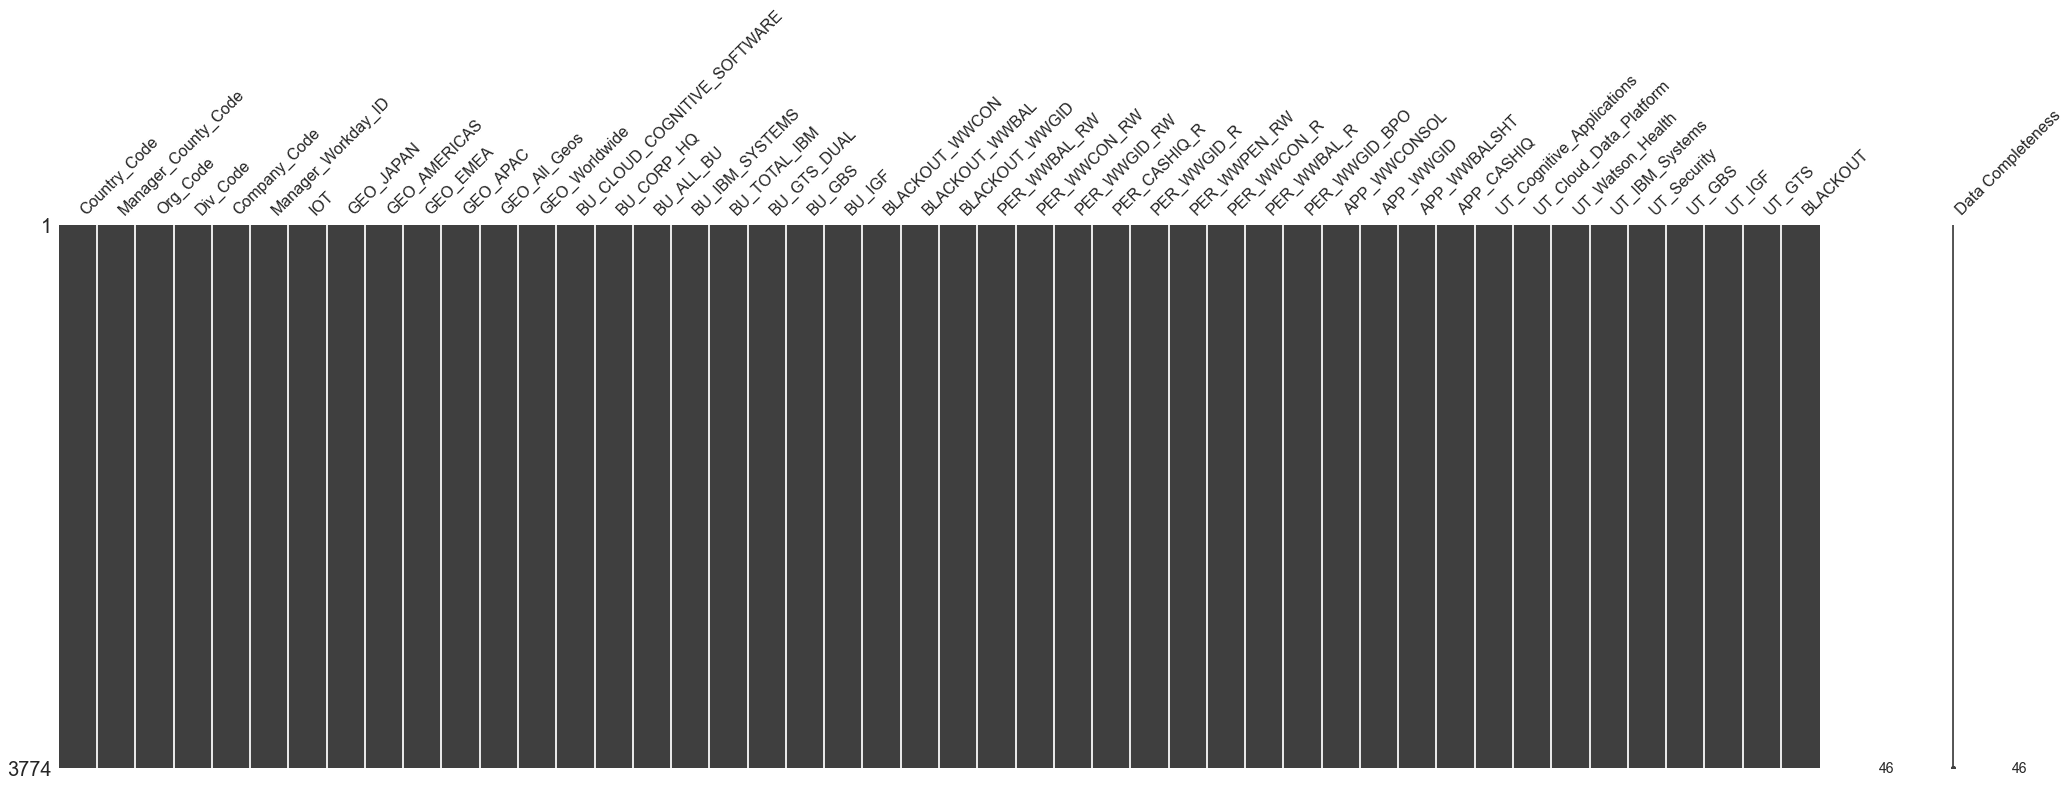

In [73]:
msno.matrix(dataset, labels=True, figsize=(35, 10))
plt.show()

### Converting ASCII to Decimal (Encoding)

In [74]:
def decimal (xcode):
    def split(xcode):
        return [char for char in xcode]
    
    xcodetodec=[]
    
    for i in xcode:
        i = ord(i)
        xcodetodec.append(i)
    
    xcodetodec = [str(x) for x in xcodetodec]
    xcodetodec = "".join([str(i) for i in xcodetodec])
    
    return xcodetodec

In [75]:
dataset['Country_Code'] = dataset['Country_Code'].apply(decimal)
dataset['Manager_County_Code'] = dataset['Manager_County_Code'].apply(decimal)
dataset['Org_Code'] = dataset['Org_Code'].apply(decimal)
dataset['Div_Code'] = dataset['Div_Code'].apply(decimal)

# Modeling

In [76]:
dataset.to_csv('FINAL.csv', index=False, header=True)

In [77]:
dataset = pd.read_csv('FINAL.csv')

#### Note: 
##### We are going to split the final dataset into Users and Targets.

In [78]:
user_columns  = ['Country_Code','Manager_County_Code','Org_Code',
                 'Div_Code','Company_Code','Manager_Workday_ID',
                 'IOT']

users = dataset.to_csv('Users.csv', columns = user_columns, index=False, header=True)
users = pd.read_csv('Users.csv')
users.astype(int)

Country_Code  Manager_County_Code  Org_Code  Div_Code  Company_Code  \
0           748057               748057      7073      7050           688   
1           545651               545651      6588      4850            39   
2           555252               555252      7073      4850            63   
3           748057               555448      7073      7050           688   
4           748057               555448      7073      7050           688   
...            ...                  ...       ...       ...           ...   
3769        545550               545550      7073      7049           684   
3770        545550               545550      7081      8455          1072   
3771        545550               545550      7080      8849           684   
3772        545550               545550      7955      4850            30   
3773        545550               545550      8871      5351           684   

      Manager_Workday_ID  IOT  
0                 518400    2  
1                 681405    1  
2                 807374    4  
3                 505388    2  
4                 511355    2  
...                  ...  ...  
3769              166701    4  
3770              166701    4  
3771              166063    4  
3772              176862    4  
3773              170800    4  

[3774 rows x 7 columns]

In [79]:
target_columns = ['GEO_JAPAN', 'GEO_AMERICAS', 'GEO_EMEA', 'GEO_APAC', 'GEO_All_Geos',
                  'GEO_Worldwide', 'BU_CLOUD_COGNITIVE_SOFTWARE', 'BU_CORP_HQ','BU_ALL_BU',
                  'BU_IBM_SYSTEMS', 'BU_TOTAL_IBM', 'BU_GTS_DUAL', 'BU_GBS', 'BU_IGF',
                  'BLACKOUT_WWCON', 'BLACKOUT_WWBAL', 'BLACKOUT_WWGID', 'PER_WWBAL_RW',
                  'PER_WWCON_RW', 'PER_WWGID_RW', 'PER_CASHIQ_R', 'PER_WWGID_R', 'PER_WWPEN_RW',
                  'PER_WWCON_R', 'PER_WWBAL_R', 'PER_WWGID_BPO', 'APP_WWCONSOL', 'APP_WWGID',
                  'APP_WWBALSHT', 'APP_CASHIQ', 'UT_Cognitive_Applications', 'UT_Cloud_Data_Platform',
                  'UT_Watson_Health', 'UT_IBM_Systems', 'UT_Security', 'UT_GBS', 'UT_IGF', 'UT_GTS',
                   'BLACKOUT']

targets = dataset.to_csv('Targets.csv', columns = target_columns, index=False, header=True)
targets = pd.read_csv('Targets.csv')
targets.astype(int)

GEO_JAPAN  GEO_AMERICAS  GEO_EMEA  GEO_APAC  GEO_All_Geos  \
0             1             0         0         0             0   
1             0             1         0         0             0   
2             0             1         0         0             0   
3             1             0         0         0             0   
4             1             0         0         0             0   
...         ...           ...       ...       ...           ...   
3769          0             0         0         1             0   
3770          0             0         0         1             0   
3771          1             0         0         0             0   
3772          0             0         0         1             0   
3773          0             0         0         1             0   

      GEO_Worldwide  BU_CLOUD_COGNITIVE_SOFTWARE  BU_CORP_HQ  BU_ALL_BU  \
0                 0                            0           0          0   
1                 0                            1           0          0   
2                 0                            1           0          0   
3                 0                            1           0          0   
4                 0                            1           0          0   
...             ...                          ...         ...        ...   
3769              0                            1           0          0   
3770              0                            0           0          0   
3771              0                            0           0          0   
3772              0                            1           0          0   
3773              0                            0           0          1   

      BU_IBM_SYSTEMS  ...  APP_CASHIQ  UT_Cognitive_Applications  \
0                  0  ...           0                          0   
1                  1  ...           0                          0   
2                  0  ...           0                          0   
3                  0  ...           0                          0   
4                  0  ...           0                          0   
...              ...  ...         ...                        ...   
3769               1  ...           0                          0   
3770               0  ...           0                          0   
3771               0  ...           0                          0   
3772               1  ...           0                          0   
3773               0  ...           0                          0   

      UT_Cloud_Data_Platform  UT_Watson_Health  UT_IBM_Systems  UT_Security  \
0                          0                 0               0            0   
1                          0                 0               0            0   
2                          0                 0               0            0   
3                          0                 0               0            0   
4                          0                 0               0            0   
...                      ...               ...             ...          ...   
3769                       0                 0               0            0   
3770                       0                 0               0            0   
3771                       0                 0               0            0   
3772                       0                 0               0            0   
3773                       0                 0               0            0   

      UT_GBS  UT_IGF  UT_GTS  BLACKOUT  
0          0       0       0         1  
1          0       0       0         0  
2          0       0       0         0  
3          0       0       0         1  
4          0       0       0         1  
...      ...     ...     ...       ...  
3769       0       0       0         0  
3770       0       0       0         1  
3771       0       0       0         0  
3772       0       0       0         0  
3773       0       0       0         0  

[3774 rows x 39 columns]

In [80]:
users = pd.read_csv('Users.csv')

In [81]:
eda(users)

Features  Duplicated Values  Duplicated Rows  Missing Values  \
0         Country_Code               3702             2209               0   
1  Manager_County_Code               3706             2209               0   
2             Org_Code               3567             2209               0   
3             Div_Code               3680             2209               0   
4         Company_Code               3673             2209               0   
5   Manager_Workday_ID               2410             2209               0   
6                  IOT               3770             2209               0   

   Unique Values Data Type  
0             72     int64  
1             68     int64  
2            207     int64  
3             94     int64  
4            101     int64  
5           1364     int64  
6              4     int64

### Scaling the data usning Standard Scaler

In [82]:
all_col = users.iloc[:,1:].columns.tolist()

In [83]:
scaler=StandardScaler()
subset=users[all_col].copy()
subset_scaled=scaler.fit_transform(subset)   

In [84]:
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

In [85]:
subset_scaled_df

Manager_County_Code  Org_Code  Div_Code  Company_Code  \
0               12.116427 -0.216748  1.460967      0.090109   
1               -0.646084 -0.745346 -0.596732     -0.375206   
2               -0.040702 -0.216748 -0.596732     -0.357999   
3               -0.028344 -0.216748  1.460967      0.090109   
4               -0.028344 -0.216748  1.460967      0.090109   
...                   ...       ...       ...           ...   
3769            -0.652452 -0.216748  1.460031      0.087242   
3770            -0.652452 -0.208029  2.775088      0.365427   
3771            -0.652452 -0.209118  3.143603      0.087242   
3772            -0.652452  0.744539 -0.596732     -0.381659   
3773            -0.652452  1.742882 -0.128138      0.087242   

      Manager_Workday_ID       IOT  
0               0.709260 -0.350799  
1               1.339455 -1.143562  
2               1.826466  1.234728  
3               0.658954 -0.350799  
4               0.682023 -0.350799  
...                  ...       ...  
3769           -0.650448  1.234728  
3770           -0.650448  1.234728  
3771           -0.652915  1.234728  
3772           -0.611165  1.234728  
3773           -0.634601  1.234728  

[3774 rows x 6 columns]

### Finding the K number using Elbow Method

Number of Clusters: 1 	Average Distortion: 2.194715842423265
Number of Clusters: 2 	Average Distortion: 1.8405452193804281
Number of Clusters: 3 	Average Distortion: 1.700206969761148
Number of Clusters: 4 	Average Distortion: 1.393939656545002
Number of Clusters: 5 	Average Distortion: 1.3433313289703732
Number of Clusters: 6 	Average Distortion: 1.183965172001631
Number of Clusters: 7 	Average Distortion: 1.0736269273530765
Number of Clusters: 8 	Average Distortion: 0.9852349416648106


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

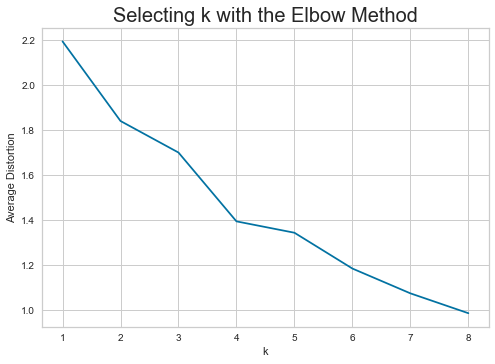

In [86]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

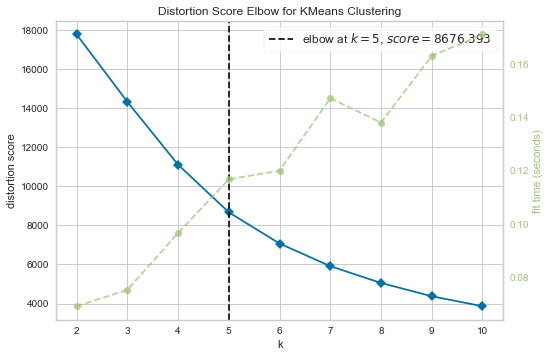

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [87]:
visualizer =  KElbowVisualizer(KMeans(random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()

### Finding the K number using Silhouette Method

For n_clusters = 2, silhouette score is 0.2932207992763312)
For n_clusters = 3, silhouette score is 0.3294160283899909)
For n_clusters = 4, silhouette score is 0.3882896363614291)
For n_clusters = 5, silhouette score is 0.4021619422711525)
For n_clusters = 6, silhouette score is 0.433897396380332)
For n_clusters = 7, silhouette score is 0.4535210491466545)
For n_clusters = 8, silhouette score is 0.4698866093303404)
For n_clusters = 9, silhouette score is 0.4891694831107294)


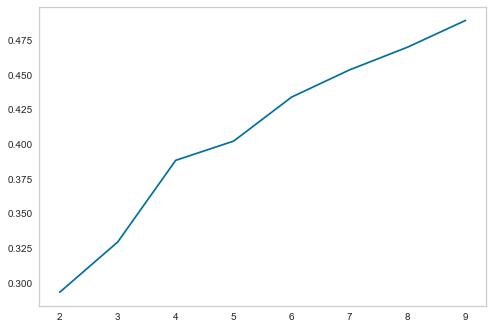

In [88]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list,sil_score)
plt.grid()

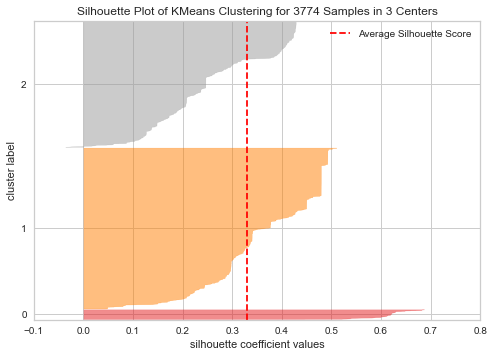

In [89]:
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

In [90]:
def find_k_similarusers(user_id, userslist, metric = 'euclidean', k=5):
    similarities=[]
    indices=[]
    output = []
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(userslist)

    distances, indices = model_knn.kneighbors(userslist.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k)
    similarities = 1-distances.flatten()
    print ('{0} most similar users to the user with index number {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_id:
            continue;

        else:
            output.append ([indices.flatten()[i], similarities.flatten()[i], userslist.iloc[user_id]['Country_Code'], 
                            userslist.iloc[user_id]['Manager_County_Code'], userslist.iloc[user_id]['Org_Code'], 
                            userslist.iloc[user_id]['Div_Code'], userslist.iloc[user_id]['Company_Code'], 
                            userslist.iloc[user_id]['Manager_Workday_ID'], userslist.iloc[user_id]['IOT']])
            
    output = pd.DataFrame(output) 
    output.columns = ['User', 'Similarity', 'Country_Code', 'Manager_County_Code', 'Org_Code', 'Div_Code', 'Company_Code', 'Manager_Workday_ID', 'IOT']
    display(output)
            
    return similarities,indices

In [91]:
similarities,indices = find_k_similarusers(84,users)

5 most similar users to the user with index number 84:



User  Similarity  Country_Code  Manager_County_Code  Org_Code  Div_Code  \
0   936         1.0        545052               545052      8884      5351   
1   140         1.0        545052               545052      8884      5351   
2    83         1.0        545052               545052      8884      5351   
3   937         1.0        545052               545052      8884      5351   
4   878         1.0        545052               545052      8884      5351   

   Company_Code  Manager_Workday_ID  IOT  
0            16              477806    3  
1            16              477806    3  
2            16              477806    3  
3            16              477806    3  
4            16              477806    3

### Recommendations

<img src="recommendation.png">

In [92]:
for indice in indices:
    selection = targets.iloc[indice]
    
selection = selection [selection > 0]
selection = selection.dropna (axis = 1, how='all')
selection

GEO_AMERICAS  BU_GTS_DUAL  BU_GBS  BLACKOUT_WWCON  PER_WWCON_RW  \
936           1.0          NaN     1.0             NaN           NaN   
140           1.0          NaN     1.0             NaN           NaN   
83            1.0          1.0     NaN             1.0           1.0   
937           1.0          NaN     1.0             NaN           NaN   
878           1.0          1.0     1.0             NaN           NaN   

     APP_WWCONSOL  BLACKOUT  
936           NaN       NaN  
140           NaN       1.0  
83            1.0       1.0  
937           NaN       1.0  
878           NaN       NaN

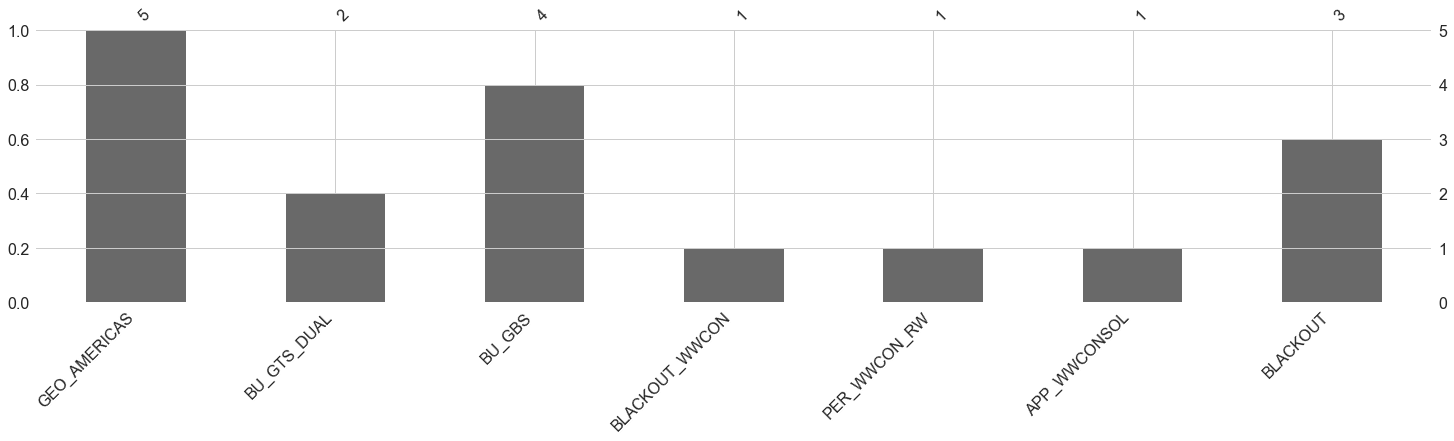

In [93]:
msno.bar(selection, labels=True, figsize=(25, 5))
plt.show()

In [94]:
all_selections = list(selection)
final = []
for selected in all_selections:
    final.append ([selected, selection[selected].value_counts().sum() * 100 / len(selection)])
    

final = pd.DataFrame(final)
final.columns = ['Recommendation', 'Match']
final.sort_values('Match', ascending=False)

Recommendation  Match
0    GEO_AMERICAS  100.0
2          BU_GBS   80.0
6        BLACKOUT   60.0
1     BU_GTS_DUAL   40.0
3  BLACKOUT_WWCON   20.0
4    PER_WWCON_RW   20.0
5    APP_WWCONSOL   20.0

##### All Recommendations: 
- GEO: AMERICAS (100% Confident)
- BU: GBS (75% Confident)
- BLACKOUT: YES (75% Confident)
- BU: GTS_DUAL (25% Confident)
- BLACKOUT: WWCON (25% Confident)
- PERSONA: WWCON_RW (25% Confident)
- APPLICATION: WWCONSOL (25% Confident)

In [95]:
best_recommendations = final['Match'] > 25.0
positions = np.flatnonzero(best_recommendations)
filtered_recommendations=final.iloc[positions]
filtered_recommendations.sort_values('Match', ascending=False)

Recommendation  Match
0   GEO_AMERICAS  100.0
2         BU_GBS   80.0
6       BLACKOUT   60.0
1    BU_GTS_DUAL   40.0

##### Best Recommendations: 
- GEO: AMERICAS (100% Confident)
- BU: GBS (75% Confident)
- BLACKOUT: YES (75% Confident)

In [96]:
print('Last Run:', datetime.now())

Last Run: 2021-08-19 12:55:51.840332


# Deployment Readiness (Production Code)

### New User

In [97]:
import requests
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import ibm_boto3
from ibm_botocore.client import Config, ClientError
import pandas as pd

In [98]:
email = 'myekrangian@ibm.com'

In [99]:
class useratt_dict(dict):
  
    def __init__(self):
        self = dict()
          
    def add(self, key, value):
        self[key] = value

In [100]:
def iot_code (region):    
    if region == "Americas":
        IOT_code = 1
    elif region == "Japan":
        IOT_code = 2
    elif region == "EMEA":
        IOT_code = 3
    elif region == "APAC":
        IOT_code = 4
    
    return (IOT_code)

In [101]:
def decimal (xcode):
    def split(xcode):
        return [char for char in xcode]
    
    xcodetodec=[]
    
    for i in xcode:
        i = ord(i)
        xcodetodec.append(i)
    
    xcodetodec = [str(x) for x in xcodetodec]
    xcodetodec = "".join([str(i) for i in xcodetodec])
    
    return xcodetodec

In [102]:
def new_user (email):
    # get employee's common attributes from BluePage
    employee_url = bluepage_api_url = "https://bluepages.ibm.com/BpHttpApisv3/slaphapi?ibmperson/mail={}.list,printable/byjson?*".format(email)
    employee_response = requests.get(employee_url)
    employee_results = employee_response.json()
    employee_att_obj = useratt_dict()
    employee_att = employee_results['search']['entry'][0]['attribute'] 

    for i in range(len(employee_att)):
        employee_att_obj.add(employee_att[i]['name'], employee_att[i]['value'][0])
        
    employee_att_obj = dict((key.lower(), value) for key, value in employee_att_obj.items()) 
    
    Country_Code = int(decimal(employee_att_obj['employeecountrycode']))
    Manager_County_Code = int(decimal(employee_att_obj['managercountrycode']))
    Manager_UID = employee_att_obj['manager'][4:13]
    Org_Code = int(decimal(employee_att_obj['hrorgunitcode']))
    Div_Code = int(decimal(employee_att_obj['div']))
    Company_Code = int(employee_att_obj['hrcompanycode'])
    
    # get employee's manager Workday ID
    manager_url = "https://bluepages.ibm.com/BpHttpApisv3/slaphapi?ibmperson/(uid={})/byjson?*".format(Manager_UID)
    manager_response = requests.get(manager_url)
    manager_results = manager_response.json()
    manager_att_obj = useratt_dict()
    manager_att = manager_results['search']['entry'][0]['attribute']
    
    for i in range(len(manager_att)):
        manager_att_obj.add(manager_att[i]['name'], manager_att[i]['value'][0])
        
    Manager_Workday_ID = int(manager_att_obj['workerId'])
    
    # get employee's working region
    iot_url = bluepage_api_url = "https://unified-profile-api.us-south-k8s.intranet.ibm.com/v3/profiles/{}/profile".format(email)
    iot_response = requests.get(iot_url)
    iot_results = iot_response.json()['content']
    IOT = iot_code(iot_results['iot'])
    
    return (Country_Code, Manager_County_Code, Org_Code, Div_Code, Company_Code, Manager_Workday_ID, IOT)

In [103]:
new_user_att = new_user (email)
new_user_att

(565755, 565755, 8775, 5351, 147, 579816, 1)

In [104]:
np_array = np.array(new_user_att)
reshaped_array = np.reshape(np_array, (1, 7))
new_user_df = pd.DataFrame(reshaped_array, columns=['Country_Code', 'Manager_County_Code', 'Org_Code', 'Div_Code', 'Company_Code', 'Manager_Workday_ID', 'IOT'])

In [105]:
new_user_df

Country_Code  Manager_County_Code  Org_Code  Div_Code  Company_Code  \
0        565755               565755      8775      5351           147   

   Manager_Workday_ID  IOT  
0              579816    1

### Loading the Training Dataset

In [106]:
COS_ENDPOINT = "https://s3.us-south.cloud-object-storage.appdomain.cloud" 
COS_API_KEY_ID = "bNTMWqticsh1gnKian0NTuxblKvLHtF9SRbBxX6DUIFn" 
COS_INSTANCE_CRN = "crn:v1:bluemix:public:cloud-object-storage:global:a/4166f16dbdf641ebb1e560acc4775da8:10a2fd10-8be4-483a-9e1b-e4a80501f2c0::"
COS_BUCKET_LOCATION = "us-south-smart"

In [107]:
def load_cos_data (filename):
    cos = ibm_boto3.client("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_INSTANCE_CRN,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT)
    get_data = cos.get_object(Bucket='knn-users',Key=filename)['Body']
    data = pd.read_csv(get_data)
    return data

In [108]:
users = load_cos_data("Users.csv")

In [109]:
targets = load_cos_data("Targets.csv")

In [110]:
frames = [new_user_df, users]
training = pd.concat(frames, ignore_index=True)

In [111]:
def find_k_similarusers(user_id, userslist, metric = 'euclidean', k=4):
    similarities=[]
    indices=[]
    output = []
    #user_id = user_id+1
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(userslist)

    distances, indices = model_knn.kneighbors(userslist.iloc[user_id, :].values.reshape(1, -1), n_neighbors = k)
    similarities = 1-distances.flatten()
    print ('{0} most similar users to the user with index number {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_id:
            continue;

        else:
            output.append ([indices.flatten()[i], similarities.flatten()[i], userslist.iloc[user_id]['Country_Code'], 
                            userslist.iloc[user_id]['Manager_County_Code'], userslist.iloc[user_id]['Org_Code'], 
                            userslist.iloc[user_id]['Div_Code'], userslist.iloc[user_id]['Company_Code'], 
                            userslist.iloc[user_id]['Manager_Workday_ID'], userslist.iloc[user_id]['IOT']])
            
    output = pd.DataFrame(output) 
    output.columns = ['User', 'Similarity', 'Country_Code', 'Manager_County_Code', 'Org_Code', 'Div_Code', 'Company_Code', 'Manager_Workday_ID', 'IOT']
    display(output)
            
    return similarities,indices

In [112]:
similarities,indices = find_k_similarusers(0,training)

4 most similar users to the user with index number 0:



User  Similarity  Country_Code  Manager_County_Code  Org_Code  Div_Code  \
0  2053         1.0        565755               565755      8775      5351   
1  2247         1.0        565755               565755      8775      5351   
2  1696         1.0        565755               565755      8775      5351   

   Company_Code  Manager_Workday_ID  IOT  
0           147              579816    1  
1           147              579816    1  
2           147              579816    1

In [113]:
for indice in indices:
    selection = targets.iloc[indice]

selection = selection [selection == 1]
selection = selection.dropna (axis = 1, how='all')
selection

GEO_All_Geos  GEO_Worldwide  BU_ALL_BU
0              NaN            NaN        NaN
2053           1.0            NaN        1.0
2247           NaN            1.0        1.0
1696           NaN            NaN        NaN

In [114]:
all_selections = list(selection)
final = []
for selected in all_selections:
    final.append ([selected, selection[selected].value_counts().sum() * 100 / len(selection)])

final = pd.DataFrame(final)
final.columns = ['Recommendation', 'Match']
final.sort_values('Match', ascending=False)

Recommendation  Match
2      BU_ALL_BU   50.0
0   GEO_All_Geos   25.0
1  GEO_Worldwide   25.0

# PLAY GROUND

In [115]:
reversed_col_list = []
result = {}

In [116]:
geo_cols = {'JAPAN': 'GEO_JAPAN', 
            'AMERICAS': 'GEO_AMERICAS', 
            'EMEA': 'GEO_EMEA', 
            'APAC': 'GEO_APAC',
            'All Geos': 'GEO_All_Geos', 
            'Worldwide': 'GEO_Worldwide'}

bu_cols = {'Cloud and Cognitive Software': 'BU_CLOUD_COGNITIVE_SOFTWARE',
           'Corp HQ Above Business Unit': 'BU_CORP_HQ',
           'All Business Units': 'BU_ALL_BU',
           'IBM Systems': 'BU_IBM_SYSTEMS',
           'Total IBM': 'BU_TOTAL_IBM',
           'GTS Dual': 'BU_GTS_DUAL',
           'GBS': 'BU_GBS', 
           'IGF': 'BU_IGF'}

blackout_cols = {'WWConsol:Blackout': 'BLACKOUT_WWCON', 
                 'WWBalsht:Blackout': 'BLACKOUT_WWBAL', 
                 'WWGID:Blackout': 'BLACKOUT_WWGID'}

persona_cols = {'WWBalsht:Planner - Read/Write': 'PER_WWBAL_RW', 
                'WWConsol:Planner - Read/Write': 'PER_WWCON_RW', 
                'WWGID:Planner - Read/Write': 'PER_WWGID_RW', 
                'Cash IQ:Analyst - Read': 'PER_CASHIQ_R', 
                'WWGID:Analyst - Read': 'PER_WWGID_R', 
                'WWPen:Planner - Read/Write': 'PER_WWPEN_RW', 
                'WWConsol:Analyst - Read': 'PER_WWCON_R', 
                'WWBalsht:Analyst - Read': 'PER_WWBAL_R',
                'WWGID:BPO Rep': 'PER_WWGID_BPO'}

app_cols = {'WWConsol': 'APP_WWCONSOL',
            'WWGID': 'APP_WWGID',
            'WWBalsht': 'APP_WWBALSHT',
            'Cash IQ': 'APP_CASHIQ'}

ut_cols = {'Cognitive Applications': 'UT_Cognitive_Applications',
           'Cloud and Data Platform': 'UT_Cloud_Data_Platform',
           'Watson Health': 'UT_Watson_Health',
           'IBM Systems': 'UT_IBM_Systems',
           'Security': 'UT_Security',
           'GBS': 'UT_GBS',
           'IGF': 'UT_IGF',
           'GTS': 'UT_GTS'}

In [117]:
col_list = [geo_cols, bu_cols, app_cols, ut_cols, blackout_cols, persona_cols]

In [118]:
for feature in col_list:
    reversed_col_list.append({value : key for (key, value) in feature.items()})

In [119]:
key_dict = {'GEO': 'GEO',
            'BU': 'Business_Unit',
            'BLACKOUT': 'Blackout_Access',
            'PER': 'Personas',
            'APP': 'Applications',
            'UT': 'Unified_Taxonomy'}

In [124]:
key_dict

{'GEO': 'GEO',
 'BU': 'Business_Unit',
 'BLACKOUT': 'Blackout_Access',
 'PER': 'Personas',
 'APP': 'Applications',
 'UT': 'Unified_Taxonomy'}

In [120]:
for key in key_dict.values():
    result[key] = []
    num_similar_users = len(selection.index)
    #print(num_similar_users)

In [125]:
selection

GEO_All_Geos  GEO_Worldwide  BU_ALL_BU
0              NaN            NaN        NaN
2053           1.0            NaN        1.0
2247           NaN            1.0        1.0
1696           NaN            NaN        NaN

In [121]:
for index in selection.index:
    vals = selection.loc[index]
    for i in vals.index:
        if vals[i] == 1:
            head = i.split('_')[0]
            encoded_val = i   
            has_val = False
            
            try:
                for feature in result[key_dict[head]]:
                    if feature['val'] == i:
                        feature['confidence'] += 100 / num_similar_users
                        has_val = True

                if not has_val:
                    result[key_dict[head]].append({
                        'val': encoded_val,
                        'confidence': 100 / num_similar_users
                    })
            except:
                print("Failed to add value {} to dictionary".format(i))

In [126]:
index

1696

In [122]:
for key in result:
    vals = result[key]
    for encoded_val in vals:
        for feature in reversed_col_list:
            if encoded_val['val'] in feature:
                vals.remove(encoded_val)
                vals.append({'val': feature[encoded_val['val']], 'confidence': encoded_val['confidence']})
                #if (encoded_val == 'PER_WWCON_R'):
                #    print('WE ARE HERE')
    
    #result['request'] = request